In [542]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import mdtraj as md
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from importlib import reload
from cycler import cycler
from itertools import chain
from functools import partial
# source modules and classes being developed 
from writhe_tools.writhe import (Writhe,
                                 to_writhe_matrix,
                                 calc_writhe_parallel,
                                 get_segments)


from writhe_tools.plots import (subplots_fes2d,
                                subplots_proj2d,
                                proj2d,
                                fes2d,
                                get_color_list,
                                box_plot)

from writhe_tools.tcca import CCA

from matplotlib.lines import Line2D

from writhe_tools.stats import Kmeans


from writhe_tools.md_tools import (ResidueDistances,
                                   get_residues,
                                   calc_rsa,
                                   calc_sa,
                                   traj_slice,
                                   load_traj,
                                   plot_distance_matrix,
                                   residue_distances,
                                   one_hot_residue_type,
                                   to_contacts
                                    )

from writhe_tools.md_tools import one_hot_residue_type as one_hot

from writhe_tools.utils import (lsdir,
                                group_by,
                                indices_stat,
                                sort_by_val_in,
                                reindex_list,
                                sort_indices_list,
                                load_array_dir,
                                filter_strs, 
                                contiguous_bool,
                                to_numpy,
                                one_hot,
                                num_str,
                                load_dict,
                                save_dict,
                                product
                                )

from writhe_tools.msm_tools import MarkovModel

from typing import Dict, List, Tuple

from writhe_tools.stats import pmf

import warnings
warnings.filterwarnings("ignore")


path = "/data/r1r2"
epi_dir = f"{path}/epi002"
apo_dir = f"{path}/apo"
cam_dir = f"{path}/cam1"
paths = [apo_dir, epi_dir, cam_dir]
labels = ['APO', 'EPI-002', '1aa']

In [603]:
protein_files = ['/data/r1r2/apo/protein.100us.dcd',
                 '/data/r1r2/epi002/protein.100us.dcd',
                 '/data/r1r2/cam1/protein.85us.dcd']


ligand_files = [lsdir(i, keyword=['dcd', 'ligand'], exclude=['wrap'], match=all)[0] for i in paths[1:]]
protein_pdb = '/data/r1r2/epi002/R2_dimer.pdb'
ligand_pdbs = [
               '/data/r1r2/epi002/R2_dimer.epi002.rename.pdb',
               '/data/r1r2/cam1/protein.ligand.pdb',
               ]
#atom_indices = md.load(protein_pdb).top.select('name CA')
dssp_paths = [lsdir(path, keyword=['dssp', 'npy'])[0] for path in paths]
r1r2_distance_paths = [lsdir(path, ['distance', 'r1r2', 'pkl'])[0] for path in paths]
residues, ca_index = get_residues(md.load(protein_pdb))
residues = residues[ca_index]
codes = np.array(list(md.load(protein_pdb).top.to_fasta()[0]))[:24]
#codes = np.array([f'{i}{j+1}' for j,i in enumerate(md.load(protein_pdb).top.to_fasta()[0])])[:24]
projs = [np.load(lsdir(path, keyword='writhe_tcca_lag_')[0])[1:] for path in paths]
# previously performed clusterings
macro_states = load_dict('density_clusters.pkl')
macro_centroids = [group_by(i, j, reduction=partial(np.mean, axis=0)) for i, j in zip(macro_states, projs)]
micro_states = load_dict('msm_clusters.pkl')
micro_centroids = [group_by(i, j, reduction=partial(np.mean, axis=0)) for i, j in zip(micro_states, projs)]

trunc = .3
pre_trunc = .3
state_width = .8
state_font_scale = 1.5


def get_longest_event(bools):
    idx = np.fromiter(map(len, event:=contiguous_bool(bools=bools)), float).argmax()
    return event[idx]


fes2d_args = dict(
      cmap="coolwarm",
      bins=55,
      n_contours=8,
      contour_lines=True,
      alpha_lines=0.35,
      alpha_contours=0.6,
      mask=False,
      scatter=True,
      scatter_alpha = .15,
      scatter_size=.05,
      scatter_stride=50,
      scatter_max=.35,
      scatter_min=.15,
      scatter_cmap="coolwarm",
      hide_ax=False,
      extend_border=0.1,
    )

# Simultaneous interactions

####  Generalizes the idea of taking the sum over 'dual contacts' - analyitically speaking, we're simply computing the joint disribution over a set of binary observables - integration gives the 'likelihood' or cumulative joint (simultaneous interactions at each frame). 

#### This is not ad hoc! However, it's worth noting that computing the full distribution is computationally infeasible but thanks to some identities of the kronocker product, the sum over each frame is very cheap

In [317]:
from writhe_tools.plots import get_extrema
from functools import reduce
from functools import partial

split = partial(np.array_split, indices_or_sections=2, axis=-1) 

def prod(vectors, sum_=False):
    if sum_:
        vectors = [v.sum(axis=-1) for v in vectors]
    return reduce(np.multiply, vectors)

In [6]:
ligand_helix = [prod(chain(*[split(np.load(f'{path}/dsspH.npy')),
                          split(to_contacts(np.load(f'{path}/ligand_distances.npy'))),]),
                          sum_=True) for path in paths]
# mn, mx = get_extrema(np.concatenate(ligand_helix))
# ligand_helix = [i / mx for i in ligand_helix]
# ligand_helix = [i.clip(0, .55) / .55 for i in ligand_helix]


protein_ligand_helix = [prod(list(chain(*[split(np.load(f'{path}/dsspH.npy')),
                       split(to_contacts(np.load(f'{path}/ligand_distances.npy')))]))
                    +  [ResidueDistances.load(f'{path}/r1r2_distance_dict.pkl').contacts()], sum_=True)
                       for path in paths]

# mn, mx = get_extrema(np.concatenate(protein_ligand_helix))
# protein_ligand_helix = [i / mx for i in protein_ligand_helix]
# protein_ligand_helix = [i.clip(0, .55) / .55 for i in protein_ligand_helix]

#protein_ligand_helix = [np.exp(protein_ligand_helix[i]) / np.sum(np.exp(protein_ligand_helix[i])) for i in range(2)]

protein_ligand = [prod(split(to_contacts(np.load(f'{path}/ligand_distances.npy')))
                    + [ResidueDistances.load(f'{path}/r1r2_distance_dict.pkl').contacts()]
                          , sum_=True)
                 for path in paths]

# mn, mx = get_extrema(np.concatenate(protein_ligand))
# protein_ligand = [i / mx for i in protein_ligand]
# protein_ligand = [i.clip(0, .55) / .55 for i in protein_ligand]

# Writhe tCCA Analysis and clustering

In [318]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, maximum_filter
from sklearn.metrics import pairwise_distances_argmin
from numpy.random import default_rng

from typing import Tuple, Optional, Union
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter
from sklearn.metrics import pairwise_distances_argmin
import matplotlib.pyplot as plt



def density_peak_clustering(
    x: np.ndarray,
    y: np.ndarray,
    bins: Union[int, Tuple[int, int]] = 100,
    smoothing_sigma: float = 1.0,
    threshold_rel: float = 0.1,
    min_distance: int = 1,
    top_n_peaks: Optional[int] = None,
    plot_peaks: bool = False
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Cluster (x, y) data by identifying density peaks from a 2D histogram and using them as fixed centroids.

    Parameters:
        x, y: Input coordinates of shape (n,)
        bins: Number of histogram bins (int or tuple of (xbins, ybins))
        smoothing_sigma: Standard deviation for Gaussian smoothing
        threshold_rel: Relative threshold (0–1) to filter weak peaks
        min_distance: Minimum distance (in bins) between detected peaks
        top_n_peaks: If given, only keep the top N density peaks
        plot_peaks: Whether to plot smoothed density with detected peaks

    Returns:
        labels: Cluster labels for each (x, y) point (shape (n,))
        peak_coords: Coordinates of the peak centroids (shape (k, 2))
    """
    # Histogram
    H, xedges, yedges = np.histogram2d(x, y, bins=bins)
    H_smooth = gaussian_filter(H, sigma=smoothing_sigma)

    # Local maxima detection
    local_max = H_smooth == maximum_filter(H_smooth, size=2 * min_distance + 1)
    threshold = H_smooth.max() * threshold_rel
    peak_mask = local_max & (H_smooth > threshold)
    peak_indices = np.argwhere(peak_mask)

    if peak_indices.shape[0] == 0:
        raise ValueError("No peaks found: try lowering threshold_rel or smoothing_sigma")

    # Convert indices to coordinates
    x_centers = 0.5 * (xedges[:-1] + xedges[1:])
    y_centers = 0.5 * (yedges[:-1] + yedges[1:])
    peak_coords = np.column_stack([x_centers[peak_indices[:, 0]], y_centers[peak_indices[:, 1]]])

    # Optionally select top-N peaks
    if top_n_peaks is not None and top_n_peaks < len(peak_coords):
        densities = H_smooth[peak_indices[:, 0], peak_indices[:, 1]]
        top_idxs = np.argsort(densities)[-top_n_peaks:]
        peak_coords = peak_coords[top_idxs]

    # Assign points to nearest peak
    data_points = np.column_stack([x, y])
    labels = pairwise_distances_argmin(data_points, peak_coords)

    # Optional plot of smoothed density and peaks
    if plot_peaks:
        plt.figure(figsize=(4, 4))
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        plt.imshow(H_smooth.T, origin='lower', extent=extent, aspect='auto', cmap='magma')
        plt.scatter(peak_coords[:, 0], peak_coords[:, 1], c='cyan', s=80, marker='x', label='Density Peaks')
        plt.title("Smoothed 2D Histogram with Density Peaks")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return labels, peak_coords


from typing import Union, Sequence

def merge_cluster_labels(
    labels: np.ndarray,
    to_merge: Union[Sequence[int], np.ndarray]
) -> np.ndarray:
    """save_dict
    Merge specified cluster labels into a single cluster and reindex the labels to be contiguous from 0.

    Parameters:
        labels: Array of original cluster labels (shape (n,))
        to_merge: Sequence of label values to merge into one cluster

    Returns:
        new_labels: New array of labels with merged clusters and contiguous relabeling
    """
    labels = np.asarray(labels)
    to_merge = set(to_merge)

    # Pick the smallest label in to_merge to represent the merged cluster
    merge_target = min(to_merge)

    # Step 1: Apply merge
    merged = labels.copy()
    merged[np.isin(merged, list(to_merge))] = merge_target

    # Step 2: Reindex to contiguous integers starting at 0
    unique = np.unique(merged)
    remap = {old: new for new, old in enumerate(unique)}
    new_labels = np.vectorize(remap.get)(merged)

    return new_labels




In [319]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle


def build_matrix_boxplot_grid(matrix: np.ndarray,
                              bottom_values: np.ndarray,
                              left_values: np.ndarray,
                              title: str = None,
                              left_title: str = None,
                              bottom_title: str = None,
                              marginal_max: int = None,
                              cmap: str = "jet",
                              figsize: tuple = (6, 6),
                              wspace: float = 0.05,
                              hspace: float = 0.05,
                              width_ratios: tuple = (1, 4, 0.15),
                              height_ratios: tuple = (1, 4, 1),
                              vmin: float = 0,
                              vmax: float = 1,
                              cbar_label: str = None,
                              ticks: list = None,
                              outline: bool = True,
                              outline_color: str = "gray",
                              outline_lw: float = .8,
                              outline_alpha: float = 0.3,
                              
                              path: str = None):
    """
    Heat‑map with marginal bar plots.

    * Matrix panel: rectangle outlines around every pixel (no internal grid).
    * Left / bottom bar panels: centred ticks only.
    """
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    spec = gridspec.GridSpec(ncols=3, nrows=3, figure=fig,
                             width_ratios=width_ratios,
                             height_ratios=height_ratios,
                             wspace=wspace, hspace=hspace)

    # ---------------------------------------------------------------- Matrix
    ax_matrix = fig.add_subplot(spec[1, 1])
    im = ax_matrix.imshow(matrix, aspect="auto", cmap=cmap,
                          vmin=vmin, vmax=vmax, alpha=.85)
    ax_matrix.tick_params(left=False, bottom=False,
                          labelleft=False, labelbottom=False)
    ax_matrix.invert_yaxis()
    if title:
        ax_matrix.set_title(title, size=18)

    # Rectangle outlines (optional)
    if outline:
        nrows, ncols = matrix.shape
        for i in range(nrows):
            for j in range(ncols):
                ax_matrix.add_patch(Rectangle(
                    (j - 0.5, i - 0.5),
                    1, 1,
                    edgecolor=outline_color,
                    facecolor="none",
                    lw=outline_lw,
                    alpha=outline_alpha
                ))

    # ---------------------------------------------------------- Left bar plot
    nrows, ncols = matrix.shape
    ax_left = fig.add_subplot(spec[1, 0], sharey=ax_matrix)
    ax_left.barh(np.arange(nrows), left_values, color="indianred", alpha=.85)
    ax_left.set_xlim(vmin, max(vmax, bottom_values.max(), left_values.max())\
                             if marginal_max is None else marginal_max
                    )
    ax_left.invert_xaxis()
    ax_left.xaxis.tick_top()
    ax_left.yaxis.tick_right()
    ax_left.minorticks_off()
    
    if left_title:
        ax_left.set_ylabel(left_title, rotation=90, labelpad=8, size=16, )
        ax_left.yaxis.set_label_position("left")

    # -------------------------------------------------------- Bottom bar plot
    ax_bottom = fig.add_subplot(spec[2, 1], sharex=ax_matrix)
    ax_bottom.bar(np.arange(ncols), bottom_values, color="skyblue", alpha=.6)
    ax_bottom.set_ylim(vmin, max(vmax, bottom_values.max(), left_values.max())\
                             if marginal_max is None else marginal_max
                      )
    ax_bottom.minorticks_off()
    ax_bottom.yaxis.tick_right()
    if bottom_title:
        ax_bottom.set_xlabel(bottom_title, labelpad=8, size=16)
        ax_bottom.xaxis.set_label_position("bottom")

    # -------------------------------------------------------------- Colorbar
    cax = fig.add_subplot(spec[1, 2])
    cbar = fig.colorbar(im, cax=cax)
    if cbar_label:
        cbar.set_label(cbar_label, rotation=-90, labelpad=16, size=16)

    # ---------------------------------------- Centre ticks on bar plots only
    pos_x = np.arange(ncols)
    pos_y = np.arange(nrows)
    ax_left.set_yticks(pos_y)
    ax_bottom.set_xticks(pos_x)

    if ticks is not None:
        ax_left.set_yticklabels(ticks,
                                ha='left',
                                va='center',
                               )
       
        ax_bottom.set_xticklabels(ticks, rotation=0)
        
    else:
        ax_left.set_yticklabels([])
        ax_bottom.set_xticklabels([])

    plt.show()

    if path is not None:
        fig.savefig(path, dpi=1000, bbox_inches='tight')


# ------------------------------ Demo / test --------------------------------


# # Test with fake data
# matrix = np.random.rand(24, 24)
# left_values = np.random.rand(24)
# bottom_values = np.random.rand(24)

# build_matrix_boxplot_grid(matrix, bottom_values, left_values, title="Demo Grid",
#                          left_title='Monomer 2', bottom_title='Monomer 1', ticks=codes,
#                          cbar_label='Protein-Protein Contacts')



# APO : Writhe tCCA Density Based clustering

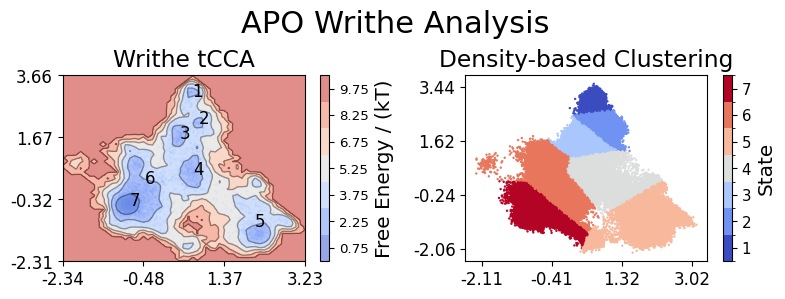

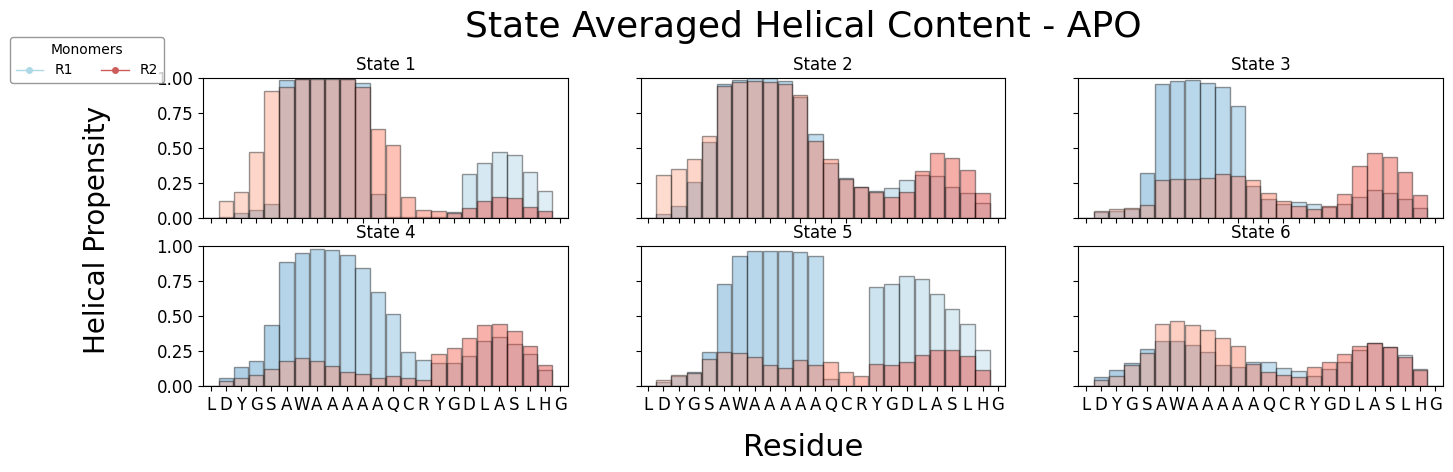

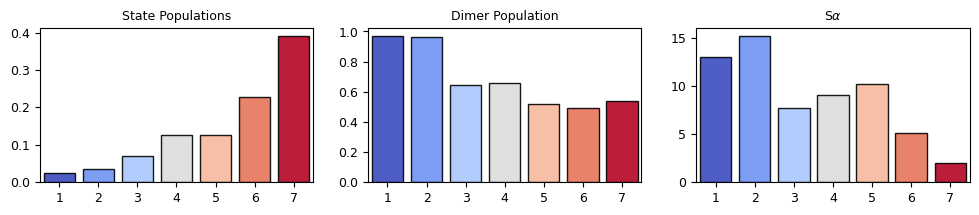

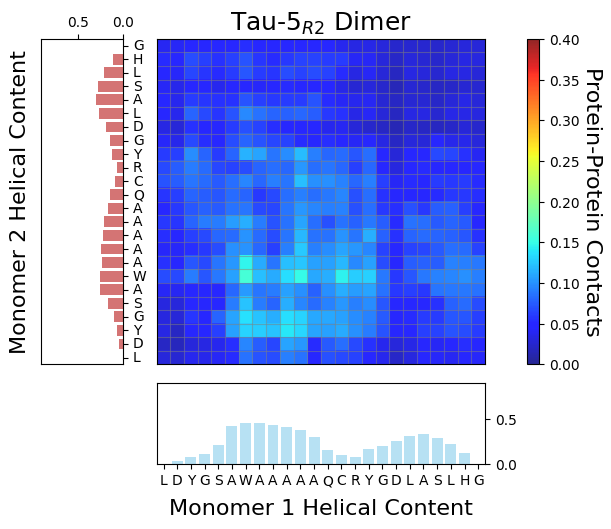

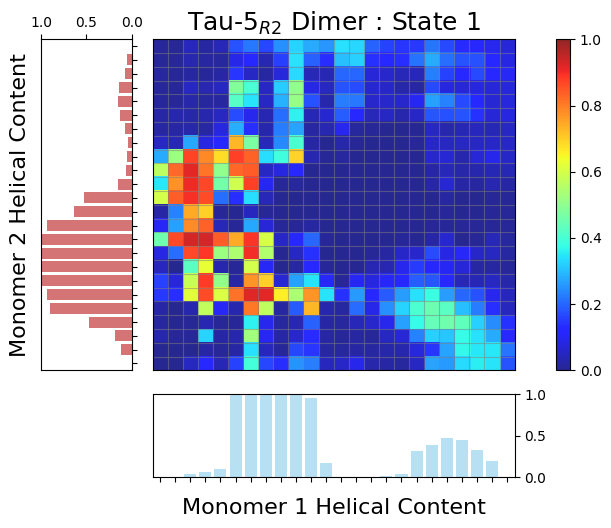

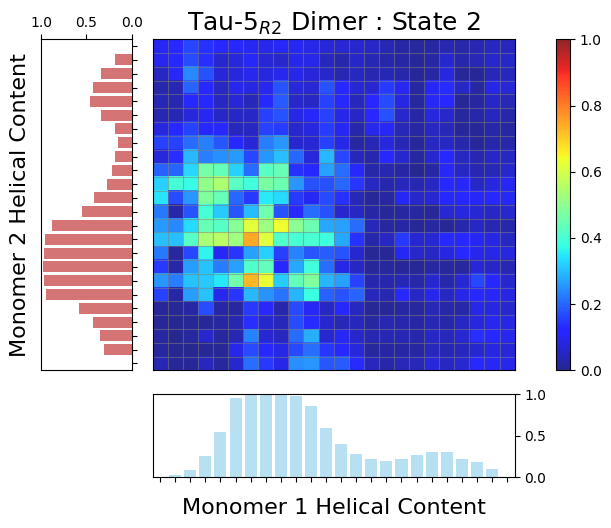

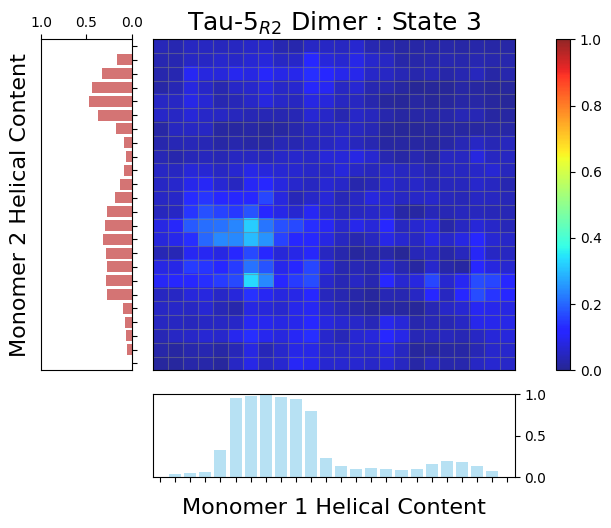

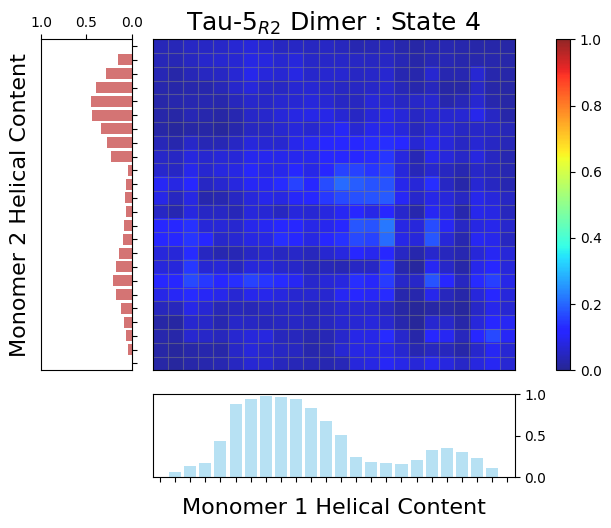

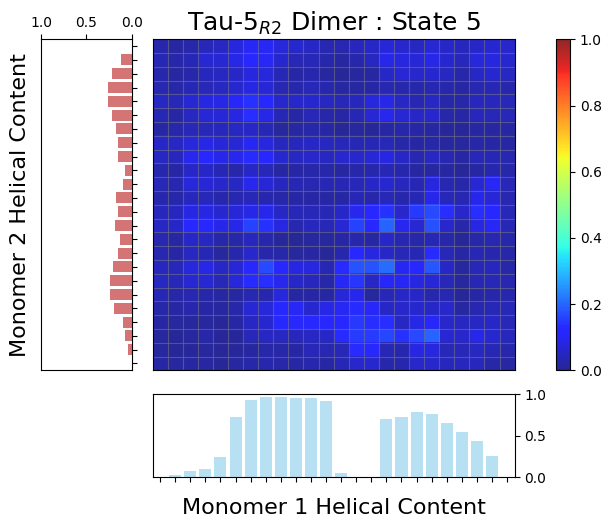

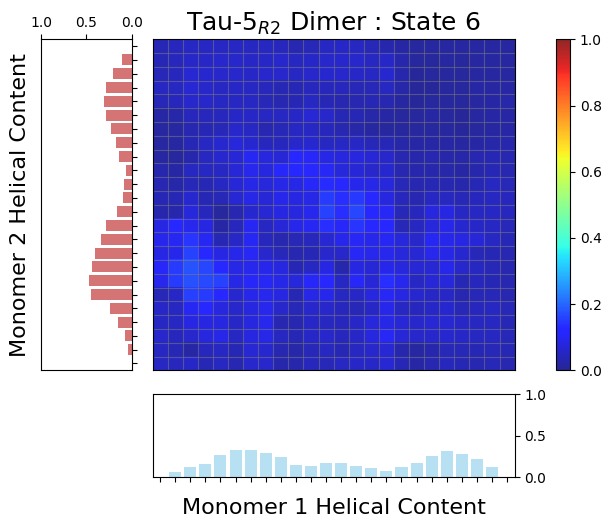

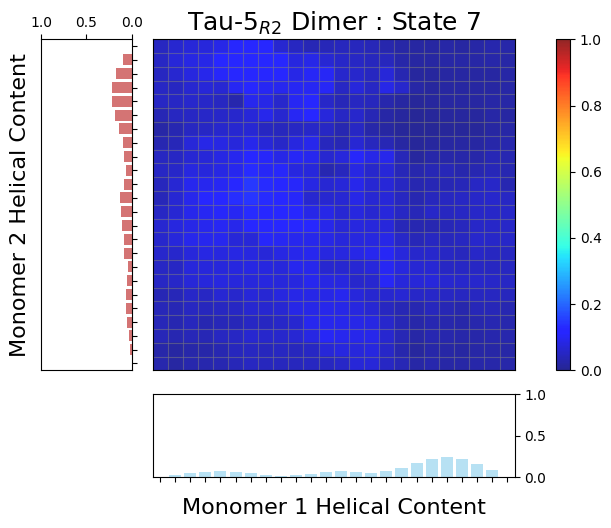

In [23]:
dtraj, centroids = density_peak_clustering(x = projs[0].T[0],
                                           y = projs[0].T[1],
                                           smoothing_sigma=1.3,
                                           threshold_rel=.05,
                                           )
dtraj = merge_cluster_labels(dtraj, [1, 2])
reindex = np.array([7, 6, 3, 4, 1, 2, 5]) - 1
dtraj = reindex[dtraj]
centroids = group_by(dtraj, projs[0], partial(np.mean, axis=0))
frames_cl = group_by(dtraj)

fig, ax = plt.subplots(1, 2, figsize=(8, 2.7))
fes2d(projs[0][:, :2], cluster_centers=centroids, ax=ax[0],
      **fes2d_args, title='Writhe tCCA', font_scale=1.2)
proj2d(projs[0][:, :2], c=dtraj, state_map=True, ax=ax[1],
       cmap='coolwarm', title = 'Density-based Clustering', font_scale=1.2)
fig.tight_layout()
fig.suptitle("APO Writhe Analysis", y=1.09, size=22)


helix = np.load(f'{paths[0]}/dsspH.npy')

fig, axes = plt.subplots(2, 3, figsize=(16, 4), sharex=True, sharey=True)

for i, (ax, frames) in enumerate(zip(axes.flat, frames_cl)):
    
    box_plot(helix[frames][:, :24].mean(0), label_stride=1, cmap="Blues_r",
             ax=ax, alpha=.4, labels=codes,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(helix[frames][:, 24:].mean(0), label_stride=1, cmap="Reds",
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Population", 
             labels=codes, title = f"State {i+1}",
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=f"R{i+1}",
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, color in enumerate(["lightblue", "indianred"])]

fig.legend(handles=legend_elements,title="Monomers",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=2,
           bbox_to_anchor = [0,1])

fig.supylabel("Helical Propensity", x=.05, size=20)
fig.supxlabel("Residue", x=.5, size=22, y=-0.08)
fig.suptitle("State Averaged Helical Content - APO", y= 1.05, size=26)

fig, ax = plt.subplots(1, 3, figsize=(12, 2))

box_plot(group_by(dtraj, reduction=lambda x : x.sum() / len(dtraj)),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(frames_cl) + 1),
         title = 'State Populations',
         rotation=0,
         trunc=0,
         width=state_width,
         pre_trunc=0,
         ymin=0,
         ax=ax[0])



box_plot(group_by(dtraj,ResidueDistances.load(f'{paths[0]}/r1r2_ca_distance_dict.pkl'
                                                ).contacts(0.6).any(1),
                           reduction=np.mean),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(frames_cl) +1),
         title = 'Dimer Population',
         rotation=0,
         trunc=0,
         pre_trunc=0,
         width=state_width,
         ax=ax[1])


box_plot(group_by(dtraj,
                np.load(f"{paths[0]}/r1r2_sa.npy").sum(-1),
                np.mean),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(frames_cl) + 1),
         title = r'S$\alpha$',
         rotation=0,
         trunc=0,
         pre_trunc=0,
         width=state_width,
         ax=ax[2])


build_matrix_boxplot_grid(ResidueDistances.load(f'{paths[0]}/r1r2_ca_distance_dict.pkl').matrix(contacts=True, cut_off=1).mean(0).T,
                          np.load(f'{paths[0]}/dsspH.npy', ).mean(0)[:24],
                          np.load(f'{paths[0]}/dsspH.npy', ).mean(0)[24:],
                          cmap='jet', title=fr'Tau-5$_{{R2}}$ Dimer',
                          bottom_title='Monomer 1 Helical Content',vmin=0, vmax=.4,
                          marginal_max=0.9,
                          left_title='Monomer 2 Helical Content',
                          cbar_label='Protein-Protein Contacts',
                          ticks=codes, path=f'{paths[0]}/protein_protein_helix_ensemble.png')

for i, frames in enumerate(frames_cl):
    build_matrix_boxplot_grid(ResidueDistances.load(f'{paths[0]}/r1r2_ca_distance_dict.pkl').matrix(contacts=True, 
                                                                                                    cut_off=1)[frames].mean(0),
                              bottom_values=np.load(f'{paths[0]}/dsspH.npy', )[frames].mean(0)[:24],
                              left_values=np.load(f'{paths[0]}/dsspH.npy', )[frames].mean(0)[24:],
                              cmap='jet', title=fr'Tau-5$_{{R2}}$ Dimer : State {i+1}',
                              bottom_title='Monomer 1 Helical Content',vmin=0, vmax=1,
                              left_title='Monomer 2 Helical Content'
    )

#dtrajs.append(dtraj)

# EPI-002 : Writhe tCCA Density Based clustering

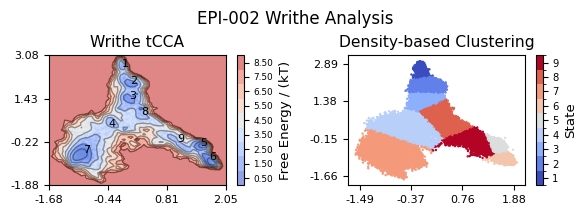

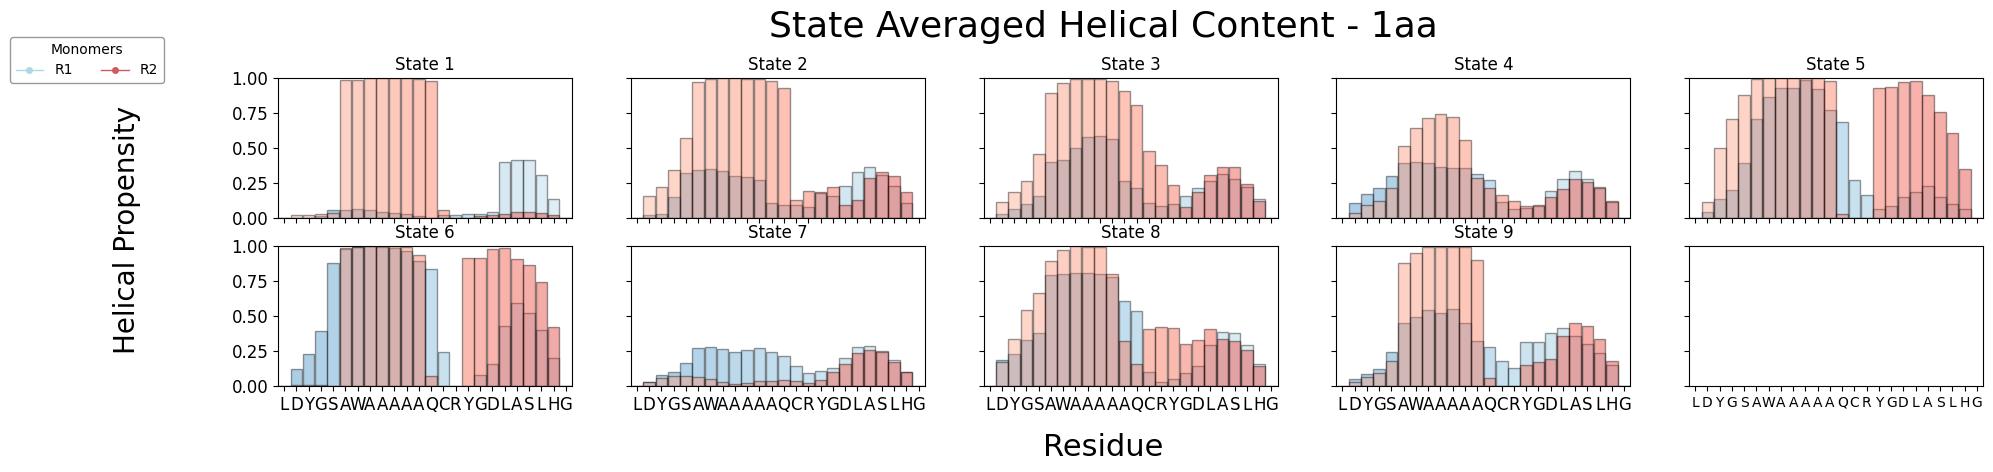

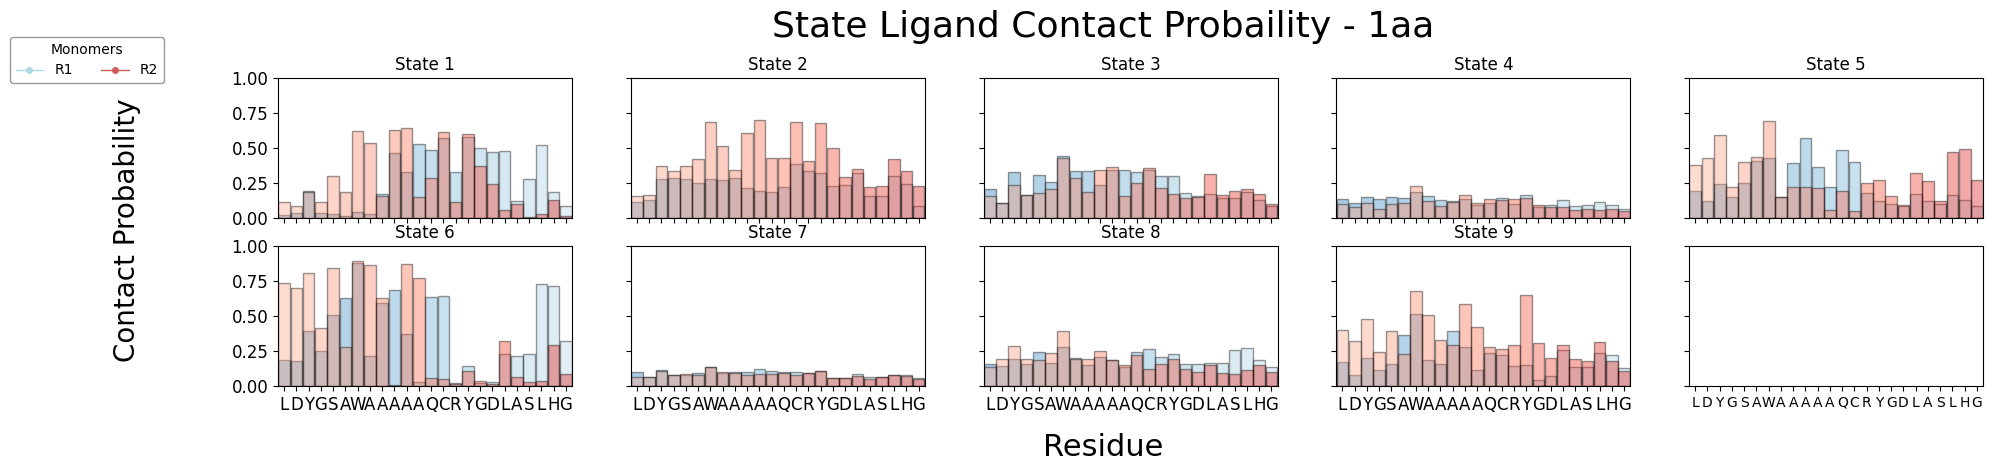

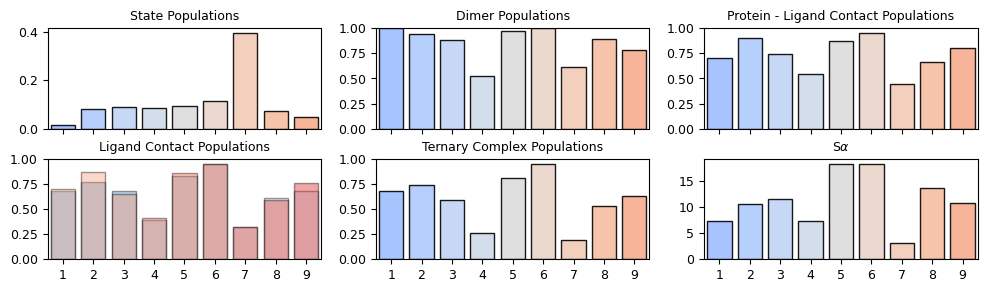

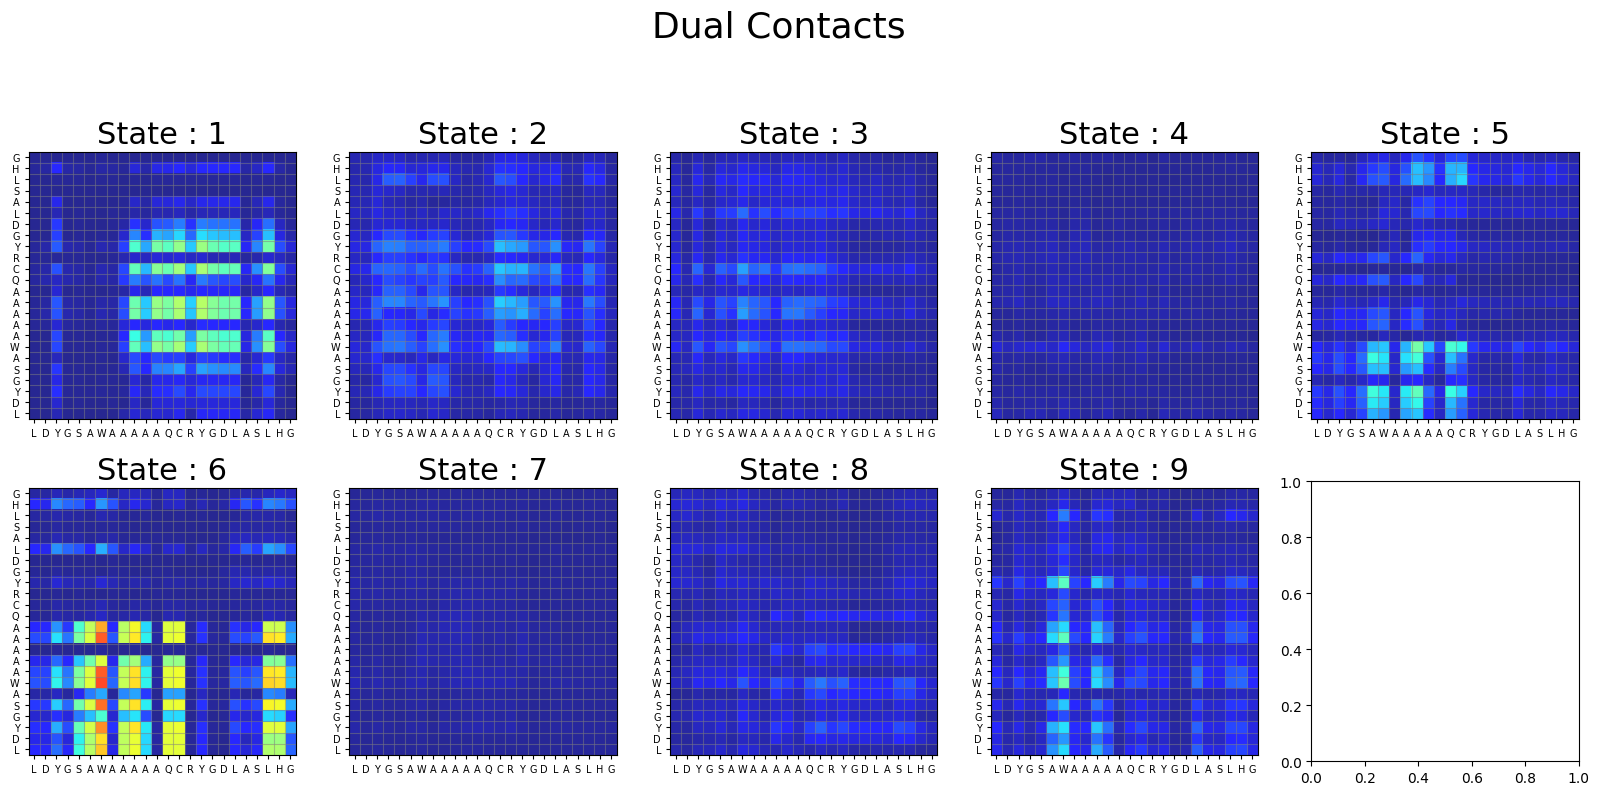

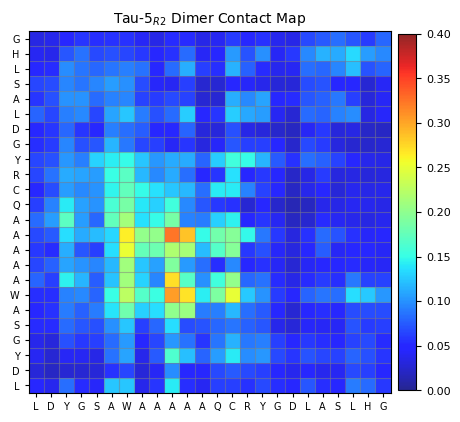

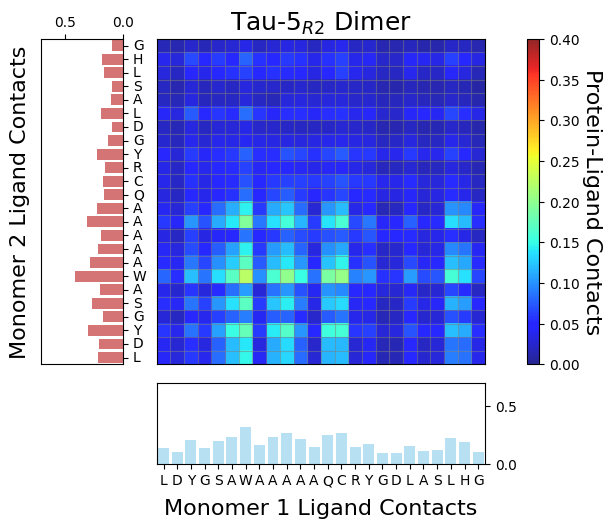

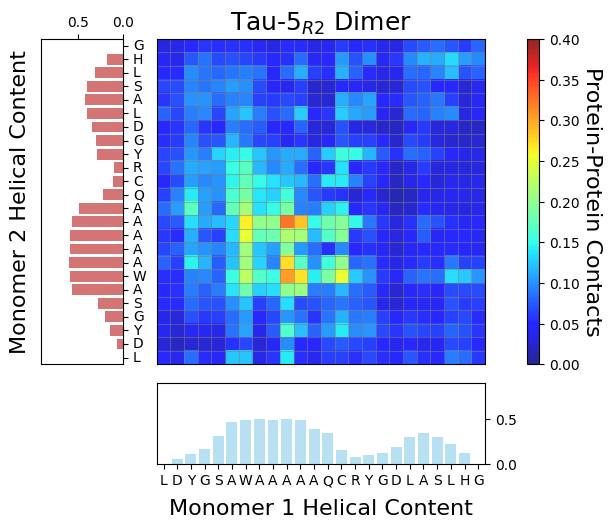

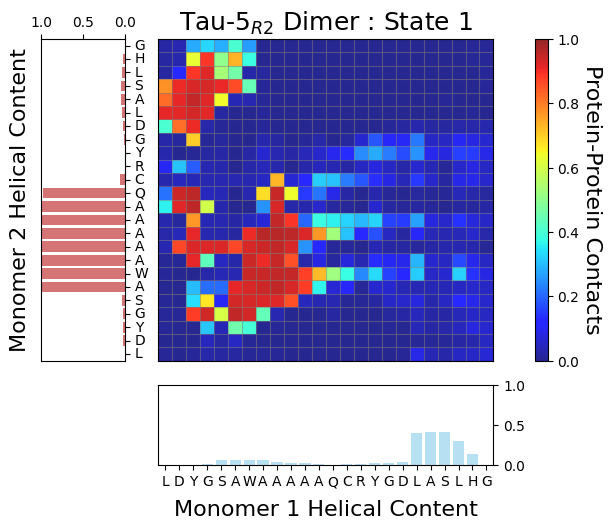

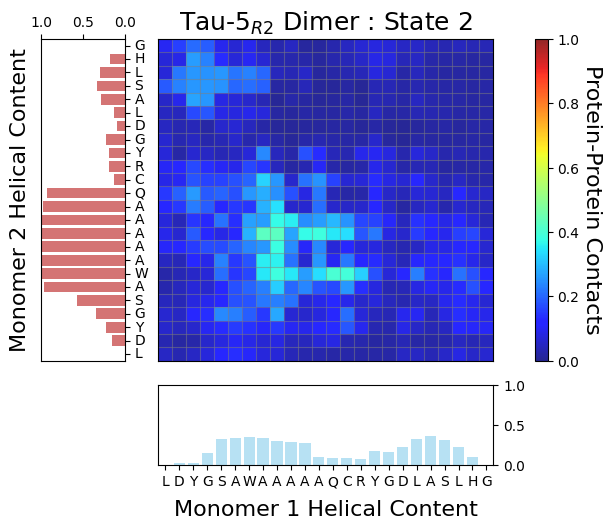

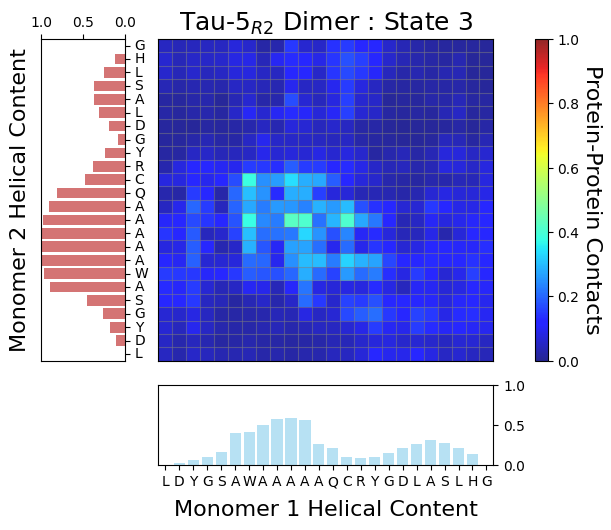

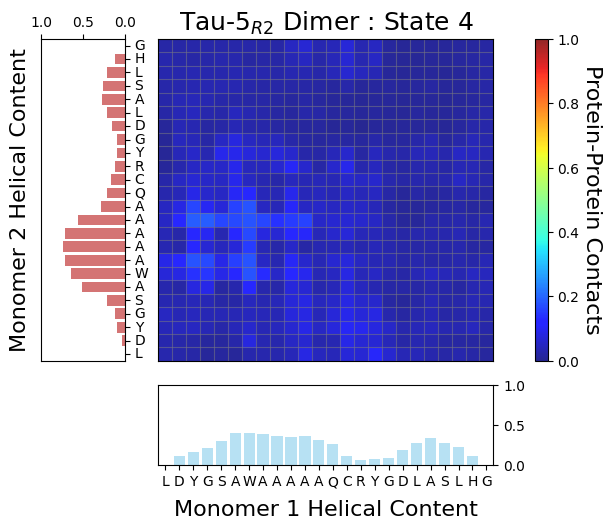

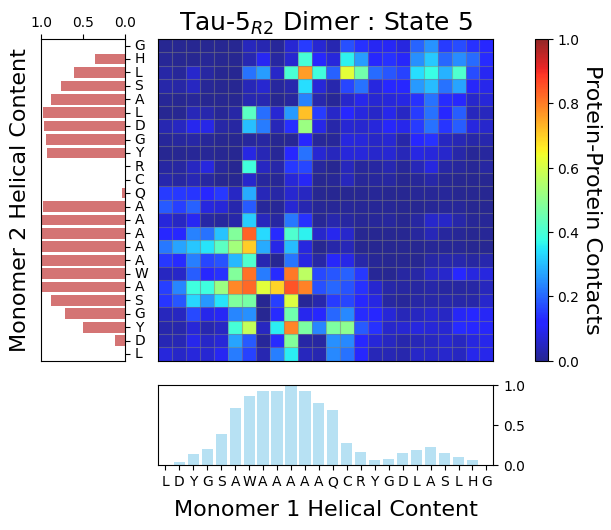

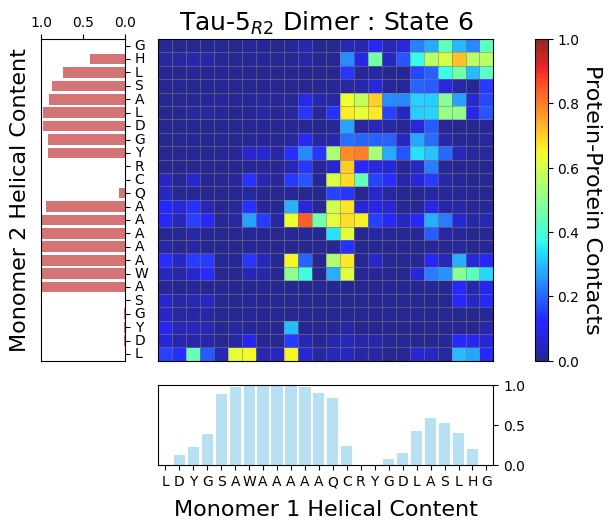

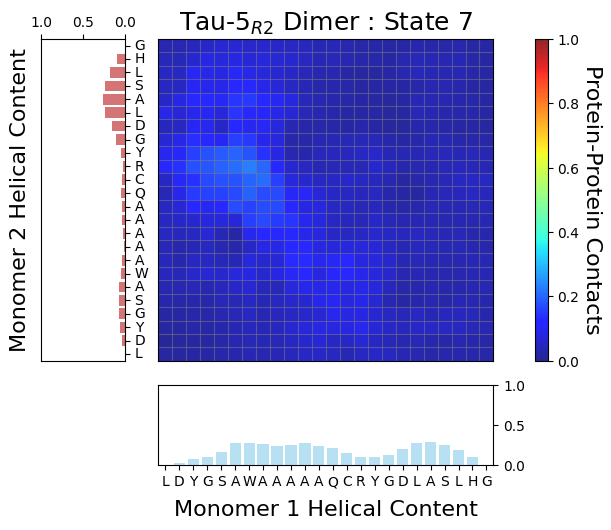

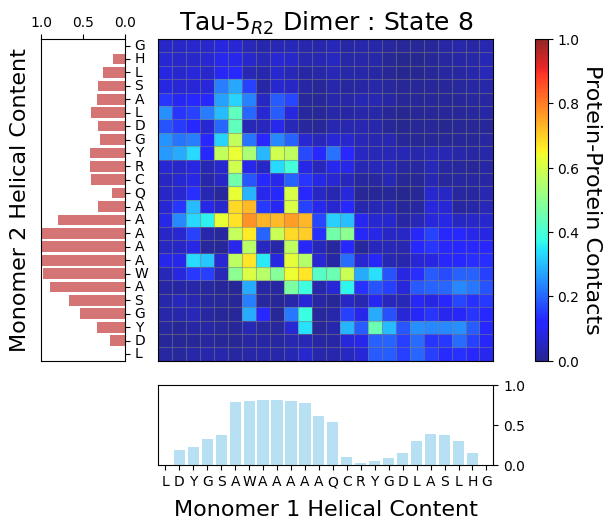

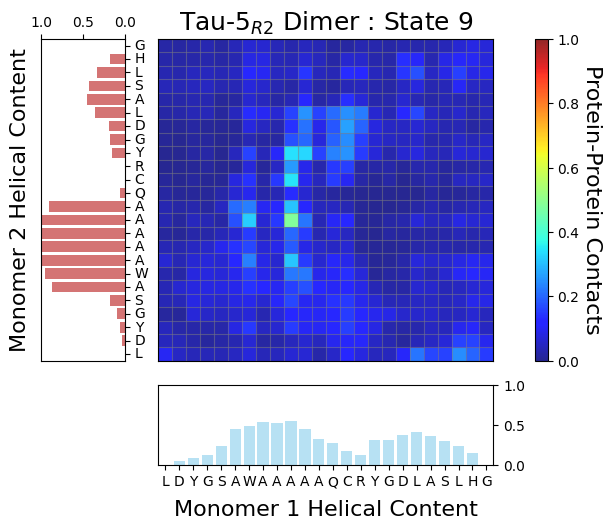

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

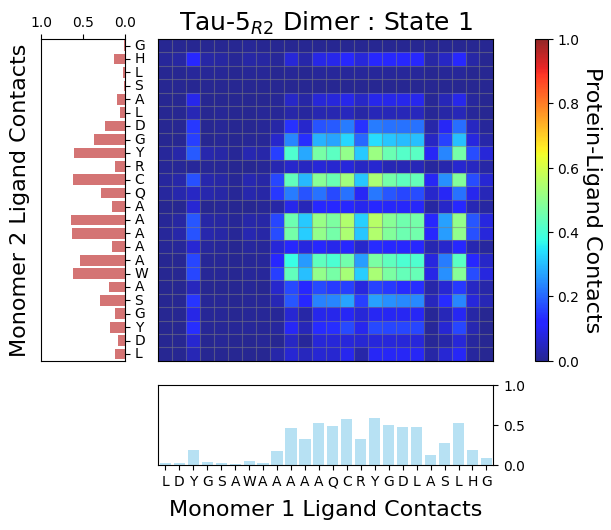

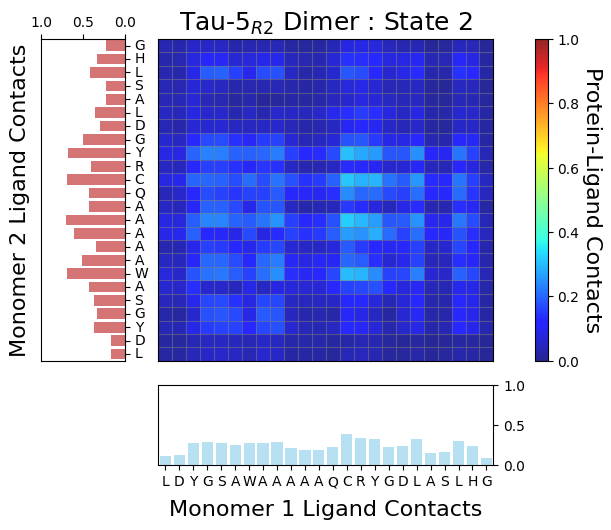

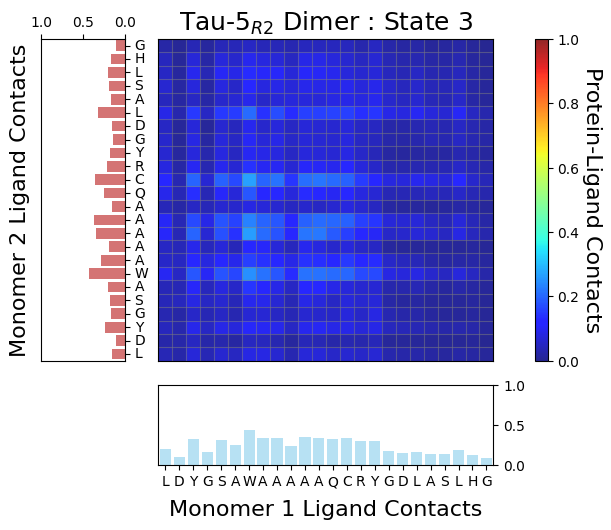

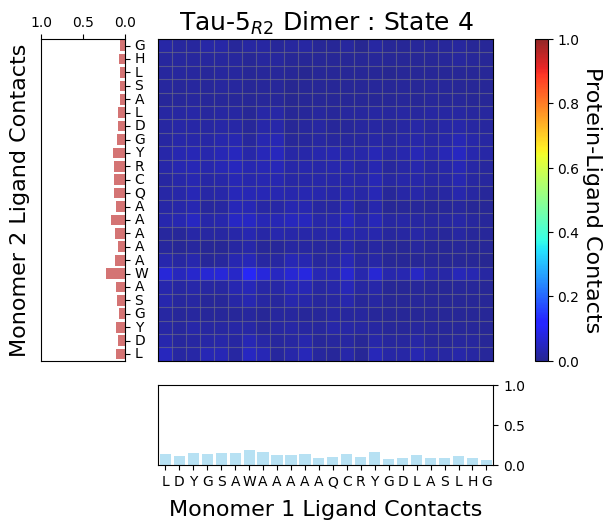

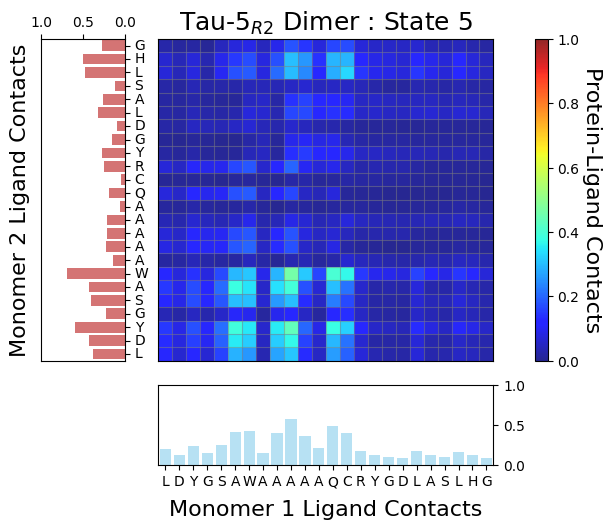

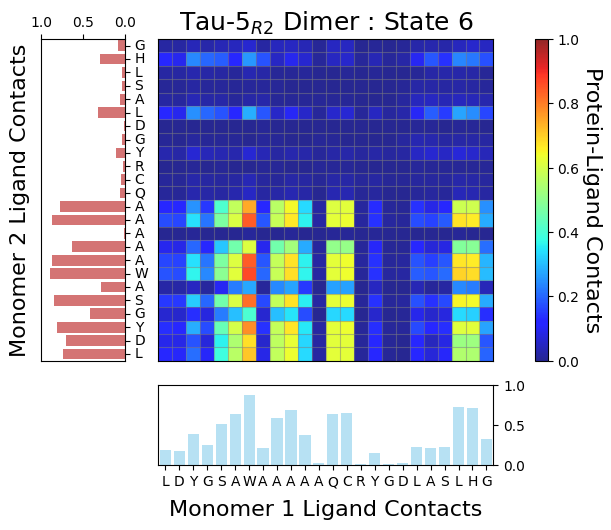

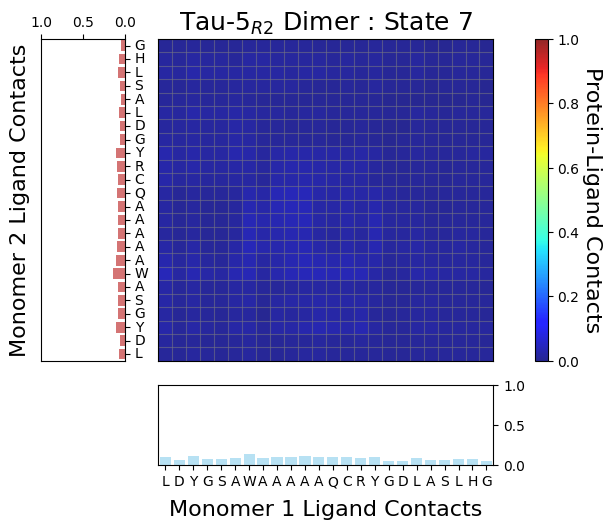

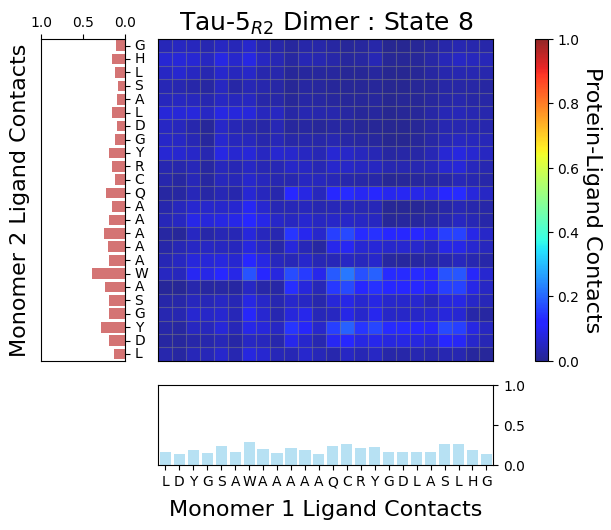

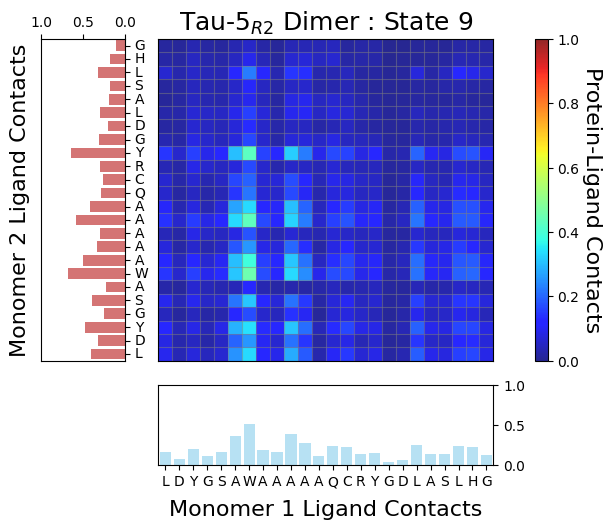

In [21]:
dtraj, centroids = density_peak_clustering(x = projs[1].T[0], y=projs[1].T[1])
dtraj = merge_cluster_labels(dtraj, [5, 6])
reindex = np.array([7, 4, 1, 3, 2, 8, 9, 5, 6]) - 1
dtraj = reindex[dtraj]
centroids = group_by(dtraj, projs[1], partial(np.mean, axis=0))
frames_cl = group_by(dtraj)

fig, ax = plt.subplots(1, 2, figsize=(6, 2))
fes2d(projs[1][:, :2], cluster_centers=centroids, ax=ax[0],
      title='Writhe tCCA', font_scale=.8, **fes2d_args)
proj2d(projs[1][:, :2], c=dtraj, state_map=True, ax=ax[1],
       cmap='coolwarm', title = 'Density-based Clustering', font_scale=.8)
fig.tight_layout()
fig.suptitle("EPI-002 Writhe Analysis", y=1.05)


helix = np.load(f'{paths[1]}/dsspH.npy')

fig, axes = plt.subplots(2, 5, figsize=(22, 4), sharex=True, sharey=True)

for i, (ax, frames) in enumerate(zip(axes.flat, frames_cl)):
    
    box_plot(helix[frames][:, :24].mean(0), label_stride=1, cmap="Blues_r",
             ax=ax, alpha=.4, labels=codes,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(helix[frames][:, 24:].mean(0), label_stride=1, cmap="Reds",
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Population", 
             labels=codes, title = f"State {i+1}",
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=f"R{i+1}",
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, color in enumerate(["lightblue", "indianred"])]

fig.legend(handles=legend_elements,title="Monomers",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=2,
           bbox_to_anchor = [0,1])

fig.supylabel("Helical Propensity", x=.05, size=20)
fig.supxlabel("Residue", x=.5, size=22, y=-0.08)
fig.suptitle("State Averaged Helical Content - 1aa", y= 1.05, size=26)

contacts = to_contacts(np.load(f'{paths[1]}/ligand_distances.npy'), 0.6)


fig, axes = plt.subplots(2, 5, figsize=(22, 4), sharex=True, sharey=True)


for i, (ax, frames) in enumerate(zip(axes.flat, frames_cl)):
    
    box_plot(contacts[frames][:, :24].mean(0), label_stride=1, cmap="Blues_r",
             ax=ax, alpha=.4, labels=codes,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(contacts[frames][:, 24:].mean(0), label_stride=1, cmap="Reds",
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Population", 
             labels=codes, title = f"State {i+1}",
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=f"R{i+1}",
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, color in enumerate(["lightblue", "indianred"])]

fig.legend(handles=legend_elements,title="Monomers",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=2,
           bbox_to_anchor = [0, 1])

fig.supylabel("Contact Probability", x=.05, size=20)
fig.supxlabel("Residue", x=.5, size=22, y=-0.08)
fig.suptitle("State Ligand Contact Probaility - 1aa", y= 1.05, size=26)

fig, axes = plt.subplots(2, 3, figsize=(12, 3), sharex=True, sharey=False)
plt.subplots_adjust(hspace=.3)


ax = axes.flat

#distances = ResidueDistances.load(f'{paths[2]}/r1r2_ca_distance_dict.pkl')

bound_fractions = group_by(dtraj,
                           ResidueDistances.load(f'{paths[1]}/r1r2_ca_distance_dict.pkl'
                                                ).contacts(1).any(1),
                           reduction=np.mean)

#print(distances.contacts(1).any(1).mean())


# 1
box_plot(group_by(dtraj, reduction=lambda x : x.sum() / len(contacts)),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) + 1),
         title = 'State Populations',
         rotation=0,
         trunc=trunc,
         width=state_width,
         pre_trunc=pre_trunc,
         ymin=0,
         ax=ax[0])


# 2
box_plot(bound_fractions,
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) + 1),
         title = 'Dimer Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[1])

# 2
box_plot(group_by(dtraj, contacts.any(1), np.mean),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = 'Protein - Ligand Contact Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[2])

# 3
box_plot(group_by(dtraj, contacts[:, :24].any(1), np.mean),
         label_stride=1,
         cmap="Blues_r",
         alpha=.4, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) + 1),
         title = 'Ligand Contact Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[3])

# 4
box_plot(group_by(dtraj, contacts[:, 24:].any(1), np.mean),
         label_stride=1,
         cmap="Reds",
         alpha=.4, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = 'Ligand Contact Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[3])

# 5
box_plot(group_by(dtraj, 
                  contacts[:, :24].any(1) * contacts[:, 24:].any(1),
                  np.mean),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = 'Ternary Complex Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[4])

# 6
box_plot(group_by(dtraj,
                np.load(f"{paths[1]}/r1r2_sa.npy").sum(-1),
                np.mean),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = r'S$\alpha$',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         width=state_width,
         ax=ax[5])

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=False, sharey=False)
fig.suptitle("Dual Contacts", y= 1.05, size=26)
for k, (frames, ax) in enumerate(zip(frames_cl, axes.flat)):
    i, j = split(contacts[frames])
    plot_distance_matrix((i.T @ j).T / len(frames),
                         ax=ax,aspect='equal',
                         xticks=codes, yticks=codes,
                         vmax=1, vmin=0,
                         label_stride=1, grid=True,
                         grid_spacing=1, grid_color='gray',
                         alpha=.85, cbar=False)
    ax.set_title(f"State : {k+1}", size=22)



plot_distance_matrix(ResidueDistances.load(f'{paths[1]}/r1r2_ca_distance_dict.pkl').matrix(contacts=True, cut_off=1).mean(0).T,
                     aspect='equal', figsize=(5, 5) ,
                     xticks=codes,yticks=codes,
                     vmax=.4,vmin=0,
                     label_stride=1,
                     grid=True,
                     grid_spacing=1,
                     grid_color='gray',
                     alpha=.85,
                     title=r'Tau-5$_{R2}$ Dimer Contact Map',)




i, j = split(contacts)

build_matrix_boxplot_grid(matrix=(i.T @ j).T / len(i),
                          bottom_values=i.mean(0),
                          left_values=j.mean(0),
                          cmap='jet', title=fr'Tau-5$_{{R2}}$ Dimer',
                          bottom_title='Monomer 1 Ligand Contacts', vmin=0, vmax=.4,
                          marginal_max=0.7,
                          left_title='Monomer 2 Ligand Contacts',ticks=codes,
                          cbar_label='Protein-Ligand Contacts',
                          path=f'{paths[1]}/protein_ligand_ensemble.png')





build_matrix_boxplot_grid(ResidueDistances.load(f'{paths[1]}/r1r2_ca_distance_dict.pkl').matrix(contacts=True, cut_off=1).mean(0).T,
                          np.load(f'{paths[1]}/dsspH.npy', ).mean(0)[:24],
                          np.load(f'{paths[1]}/dsspH.npy', ).mean(0)[24:],
                          cmap='jet', title=fr'Tau-5$_{{R2}}$ Dimer',
                          bottom_title='Monomer 1 Helical Content',vmin=0, vmax=.4,
                          marginal_max=0.9,
                          left_title='Monomer 2 Helical Content',
                          cbar_label='Protein-Protein Contacts',
                          ticks=codes, path=f'{paths[1]}/protein_protein_helix_ensemble.png')




for i, frames in enumerate(frames_cl):
    build_matrix_boxplot_grid(ResidueDistances.load(f'{paths[1]}/r1r2_ca_distance_dict.pkl').matrix(contacts=True, 
                                                                                                    cut_off=1)[frames].mean(0).T,
                              bottom_values = np.load(f'{paths[1]}/dsspH.npy', )[frames].mean(0)[:24],
                              left_values = np.load(f'{paths[1]}/dsspH.npy', )[frames].mean(0)[24:],
                              cmap='jet', title=fr'Tau-5$_{{R2}}$ Dimer : State {i+1}',
                              bottom_title='Monomer 1 Helical Content',vmin=0, vmax=1,
                              left_title='Monomer 2 Helical Content', ticks=codes,
                              cbar_label='Protein-Protein Contacts',
                              path=f'{paths[1]}/protein_protein_helix_state_{i+1}.png'
                              
                              )
    
plt.figure()
plt.figure()

for k, frames in enumerate(frames_cl):
    i, j = split(contacts[frames])
    build_matrix_boxplot_grid(matrix=(i.T @ j).T / len(frames),
                              bottom_values=i.mean(0),
                              left_values=j.mean(0),
                              cmap='jet', title=fr'Tau-5$_{{R2}}$ Dimer : State {k+1}',
                              bottom_title='Monomer 1 Ligand Contacts', vmin=0, vmax=1,
                              left_title='Monomer 2 Ligand Contacts',ticks=codes,
                              cbar_label='Protein-Ligand Contacts',
                              path=f'{paths[1]}/protein_ligand_state_{k+1}.png'
                             )
    
#fig.tight_layout()   

#dtrajs.append(dtraj)

# 1aa : Writhe tCCA Density Based clustering

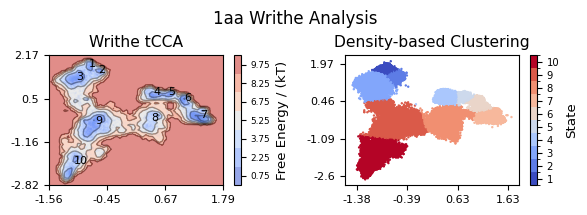

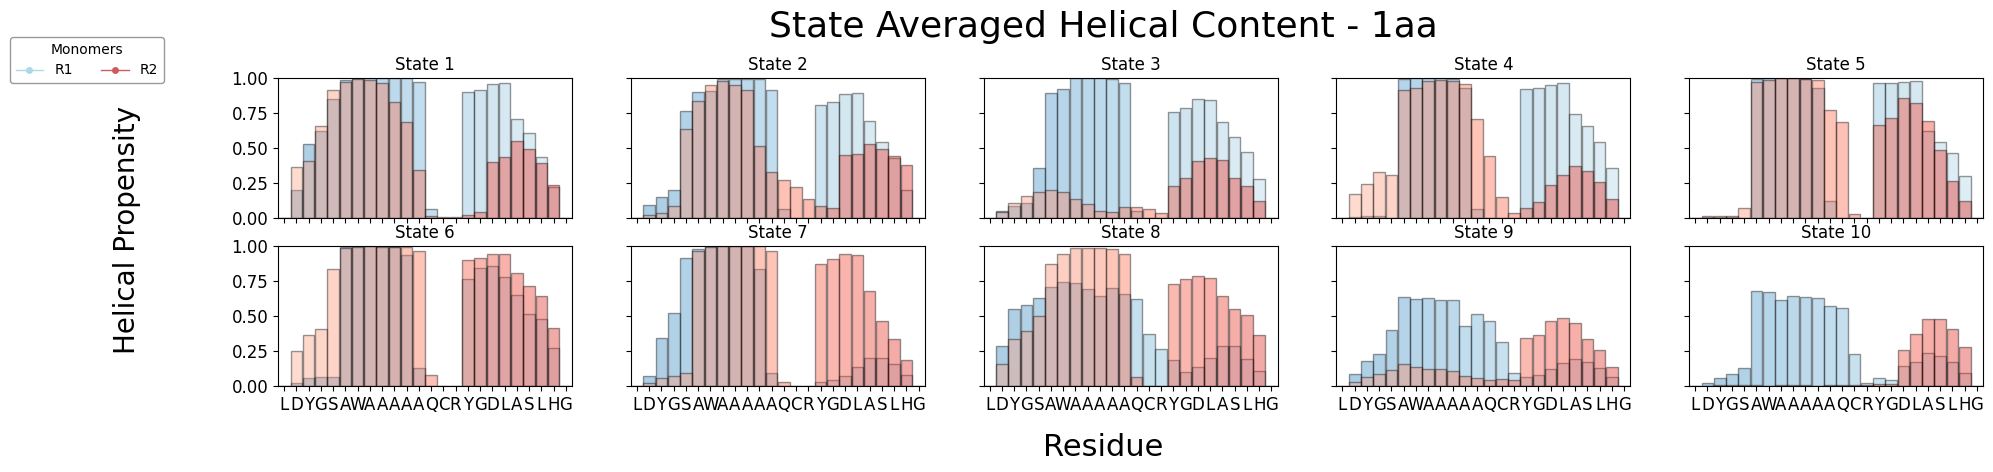

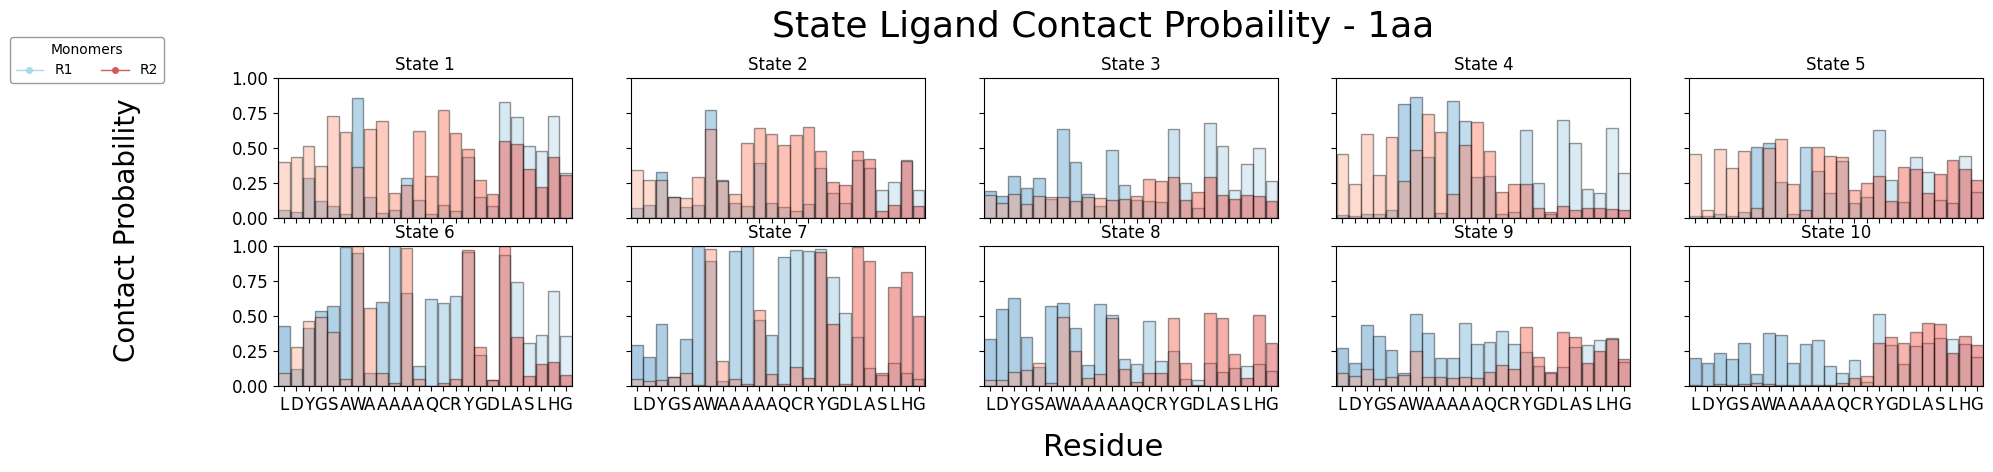

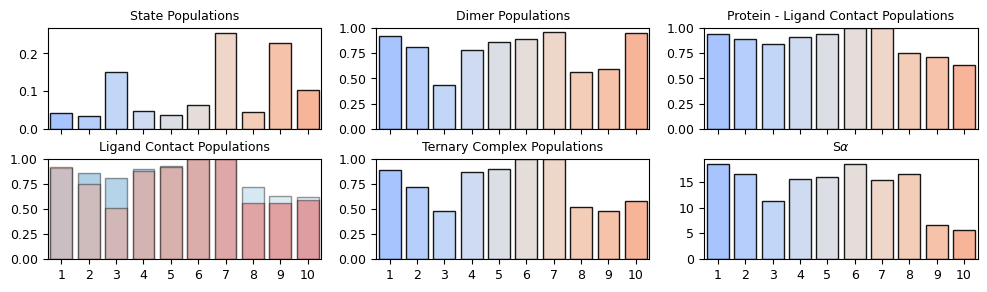

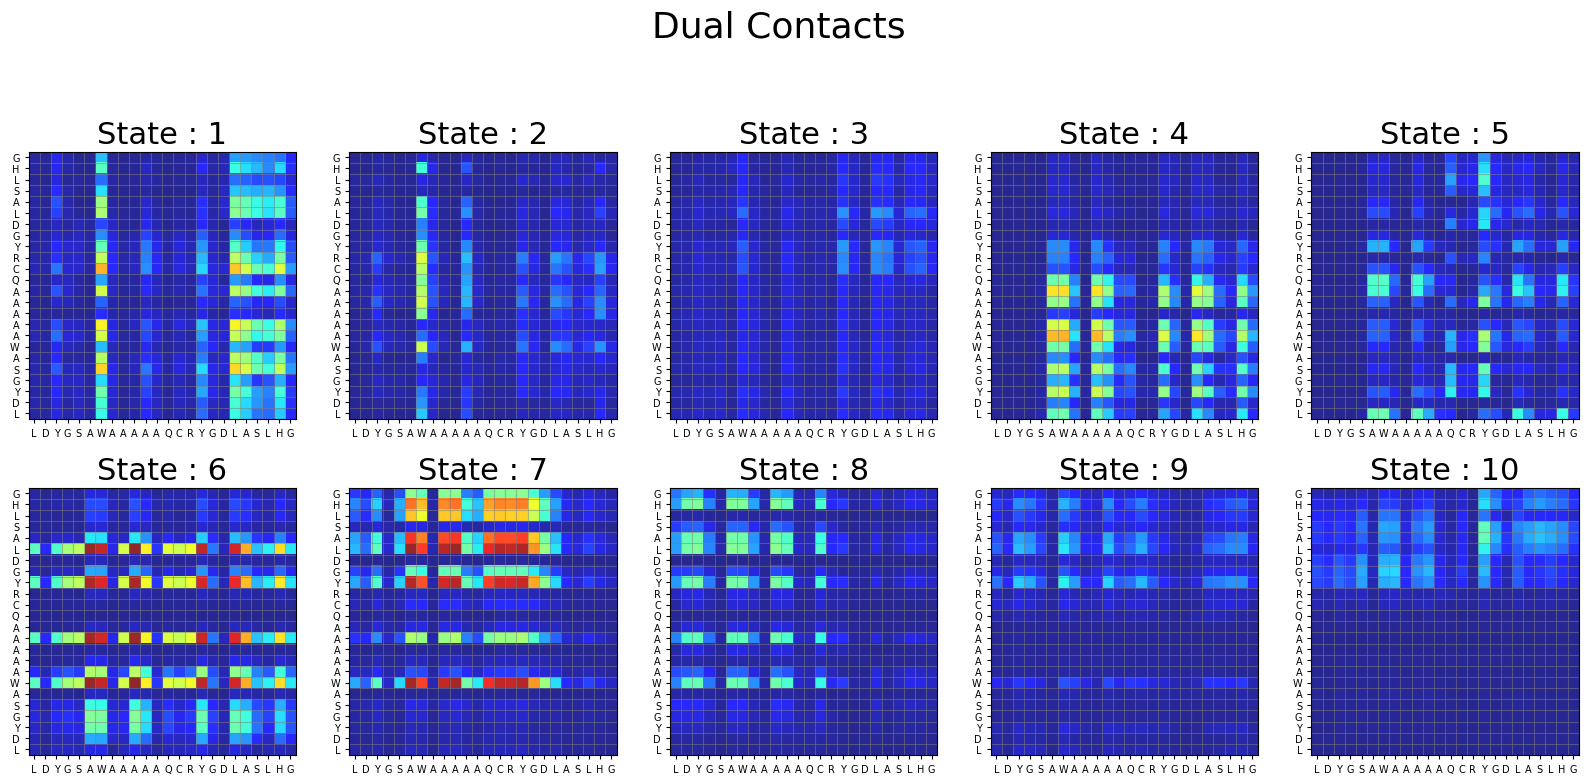

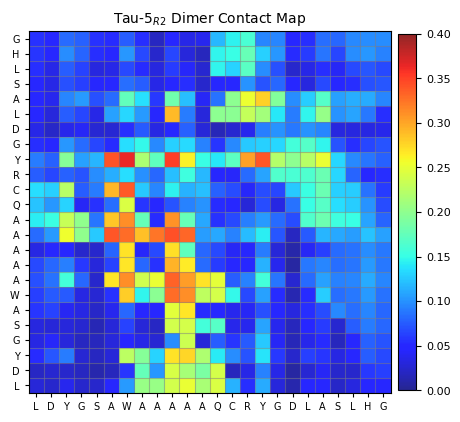

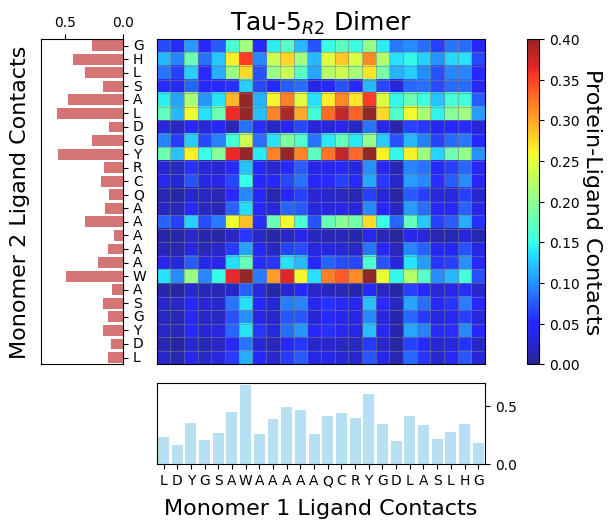

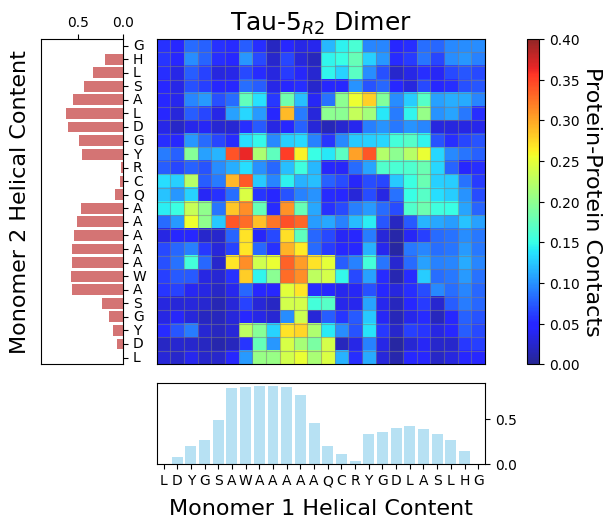

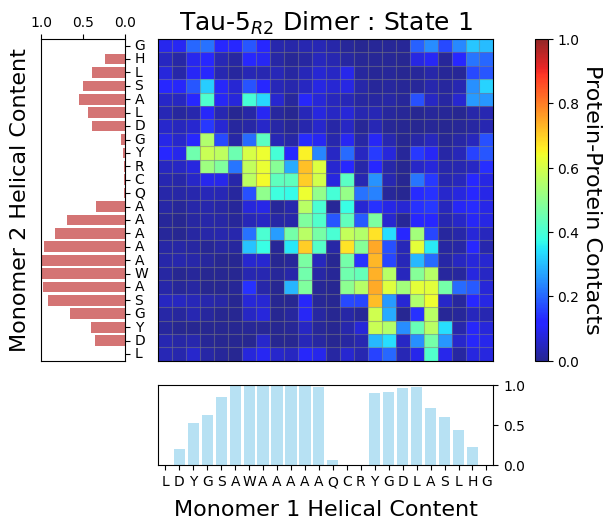

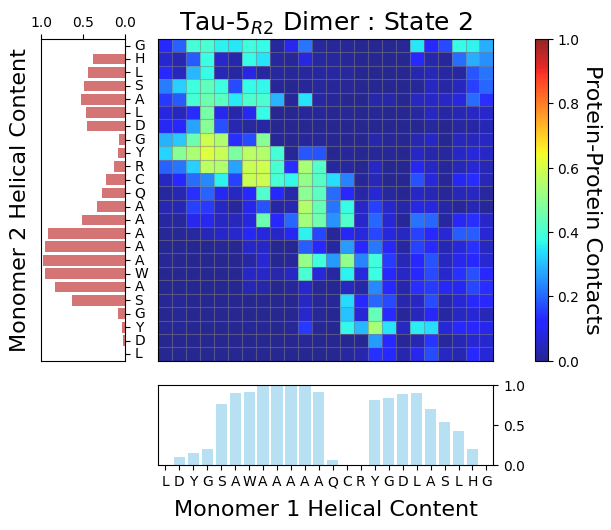

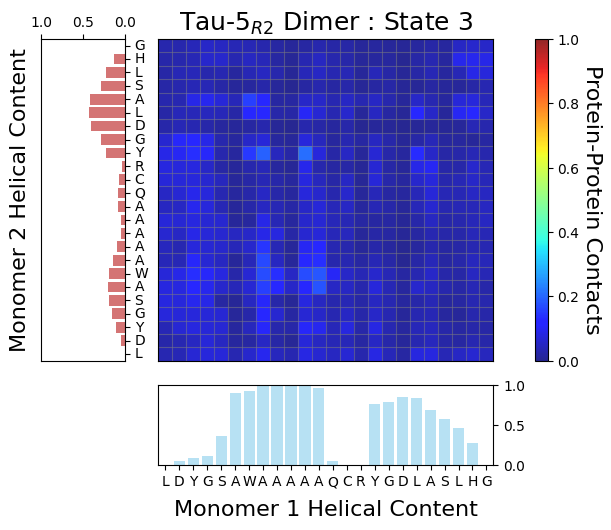

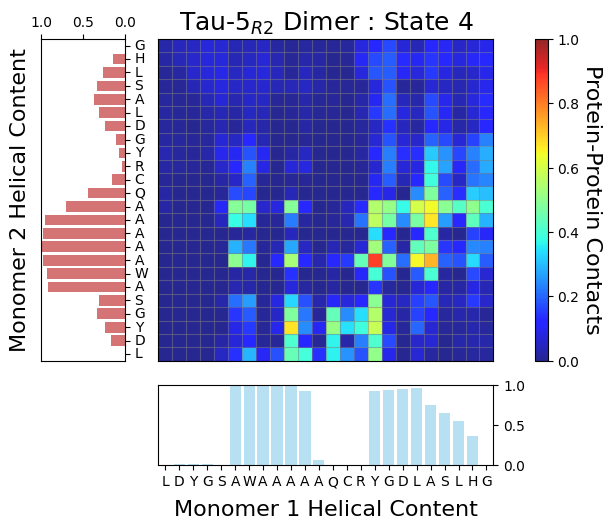

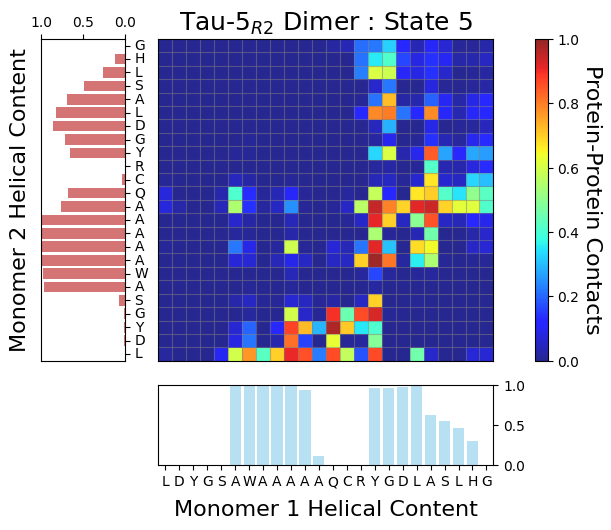

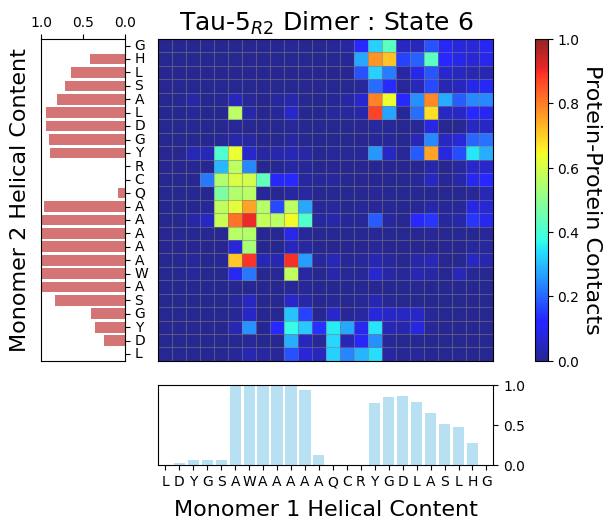

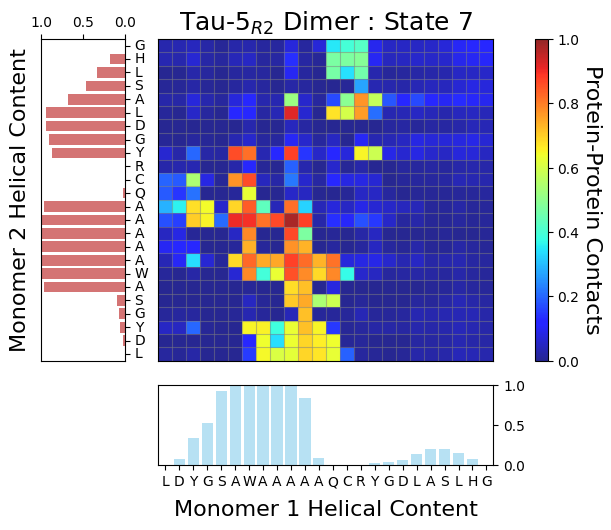

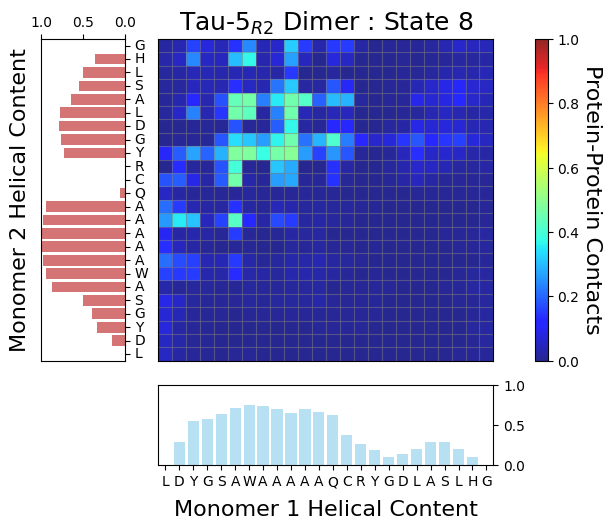

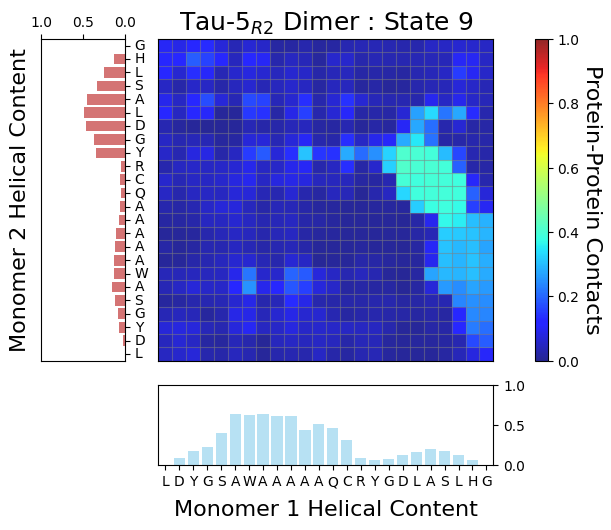

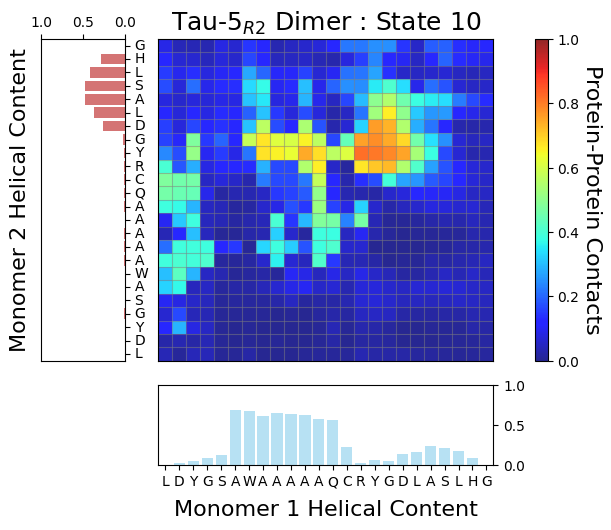

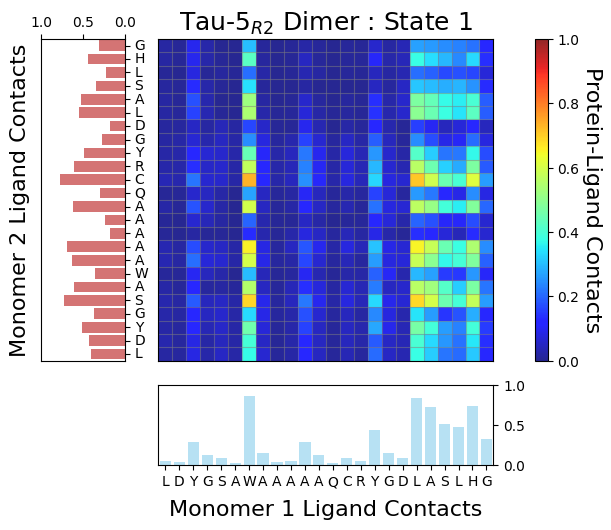

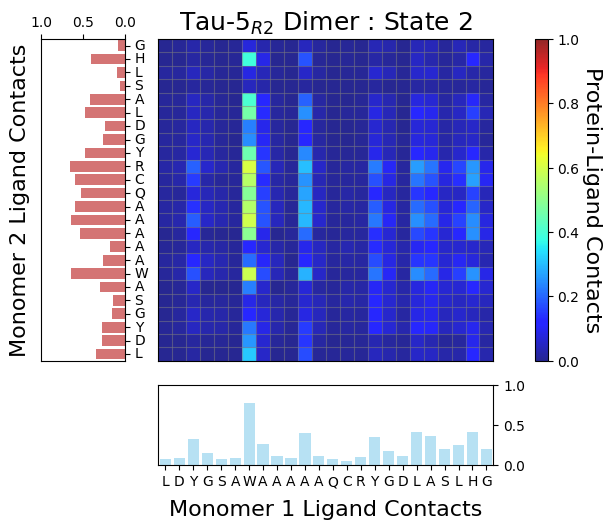

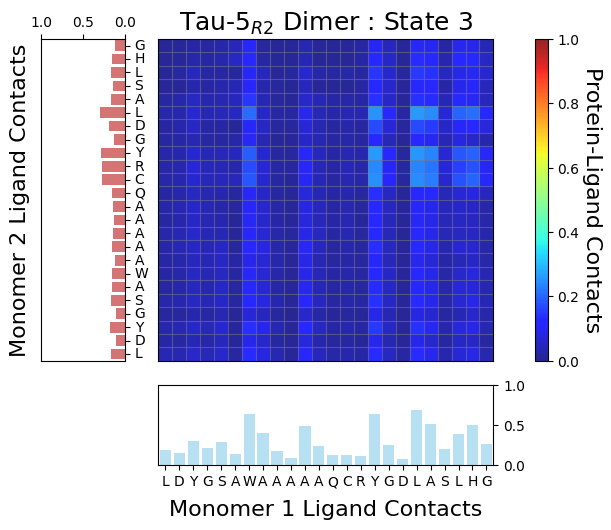

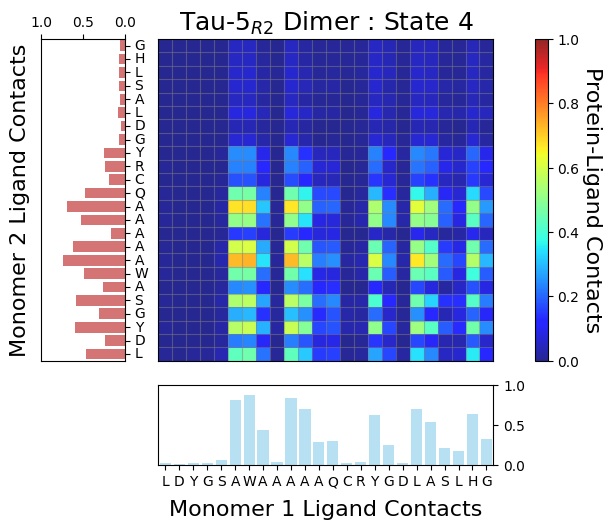

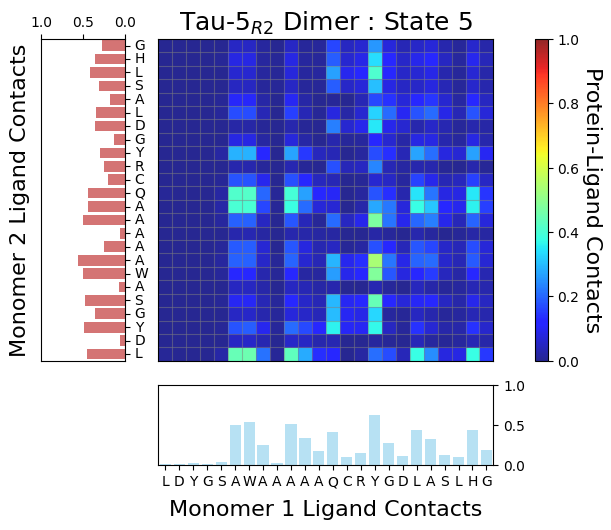

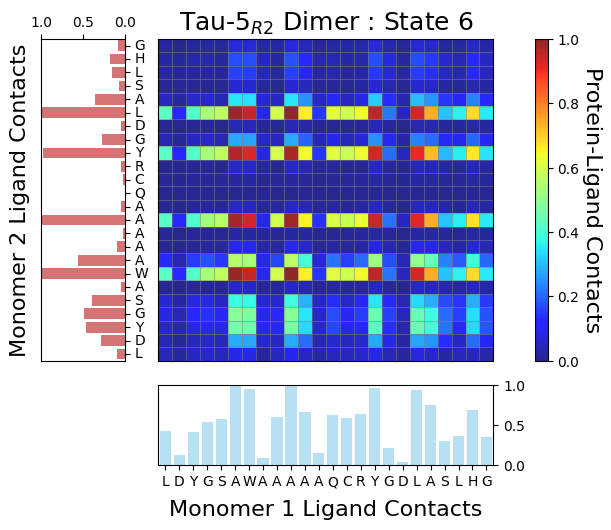

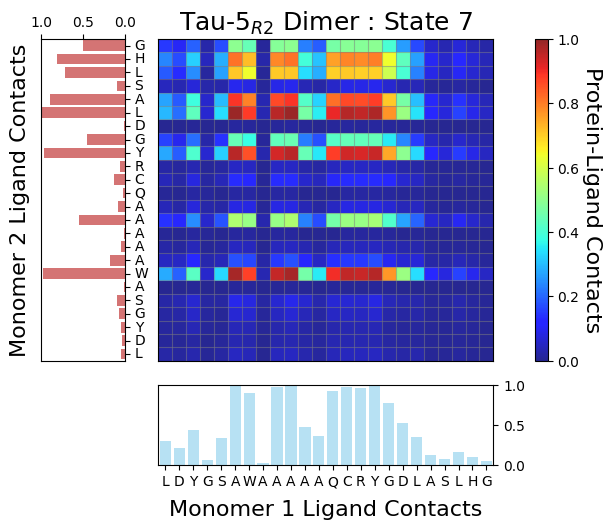

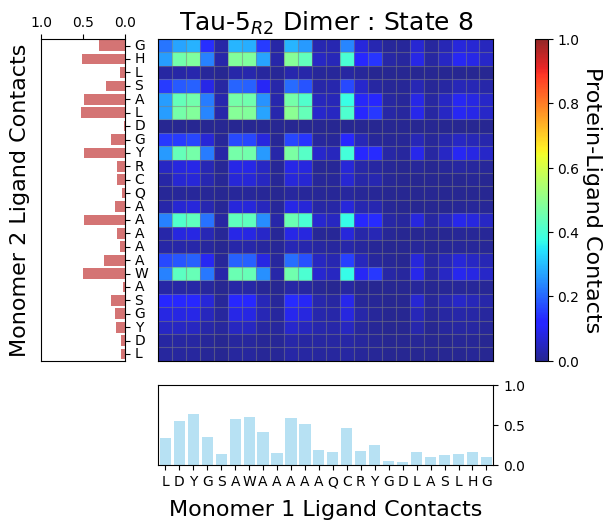

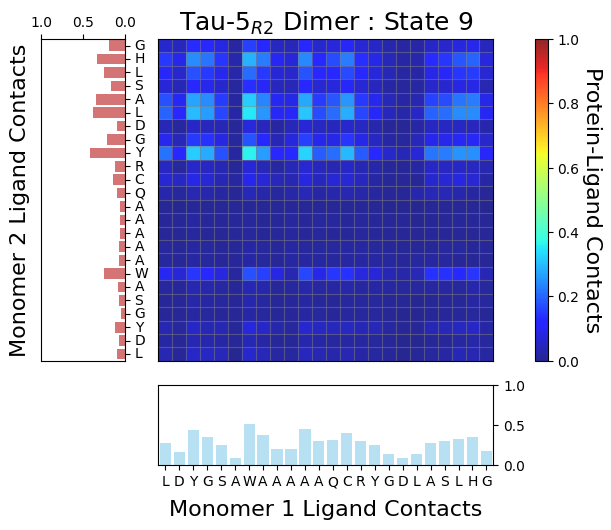

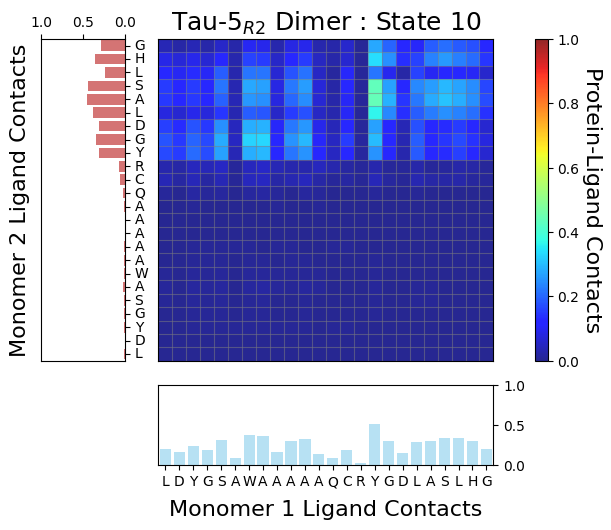

In [20]:
dtraj, centroids = density_peak_clustering(x = projs[2].T[0],
                                            y=projs[2].T[1],
                                            smoothing_sigma=1.3,
                                            threshold_rel=.05)

dtraj = merge_cluster_labels(dtraj, [1, 3])
dtraj = merge_cluster_labels(dtraj, [0, 2])
reindex = np.array([10, 3, 1, 9, 2, 4, 8, 5, 6, 7]) - 1
dtraj = reindex[dtraj]
centroids = group_by(dtraj, projs[2], partial(np.mean, axis=0))
frames_cl = group_by(dtraj)

fig, ax = plt.subplots(1, 2, figsize=(6, 2))
fes2d(projs[2][:, :2], cluster_centers=centroids, ax=ax[0],
      title='Writhe tCCA', font_scale=.8, **fes2d_args)
proj2d(projs[2][:, :2], c=dtraj, state_map=True, ax=ax[1],
       cmap='coolwarm', title = 'Density-based Clustering', font_scale=.8)
fig.tight_layout()
fig.suptitle("1aa Writhe Analysis", y=1.05)



helix = np.load(f'{paths[2]}/dsspH.npy')

fig, axes = plt.subplots(2, 5, figsize=(22, 4), sharex=True, sharey=True)

for i, (ax, frames) in enumerate(zip(axes.flat, frames_cl)):
    
    box_plot(helix[frames][:, :24].mean(0), label_stride=1, cmap="Blues_r",
             ax=ax, alpha=.4, labels=codes,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(helix[frames][:, 24:].mean(0), label_stride=1, cmap="Reds",
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Population", 
             labels=codes, title = f"State {i+1}",
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=f"R{i+1}",
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, color in enumerate(["lightblue", "indianred"])]

fig.legend(handles=legend_elements,title="Monomers",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=2,
           bbox_to_anchor = [0,1])

fig.supylabel("Helical Propensity", x=.05, size=20)
fig.supxlabel("Residue", x=.5, size=22, y=-0.08)
fig.suptitle("State Averaged Helical Content - 1aa", y= 1.05, size=26)

contacts = to_contacts(np.load(f'{paths[2]}/ligand_distances.npy'), 0.6)


fig, axes = plt.subplots(2, 5, figsize=(22, 4), sharex=True, sharey=True)


for i, (ax, frames) in enumerate(zip(axes.flat, frames_cl)):
    
    box_plot(contacts[frames][:, :24].mean(0), label_stride=1, cmap="Blues_r",
             ax=ax, alpha=.4, labels=codes,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(contacts[frames][:, 24:].mean(0), label_stride=1, cmap="Reds",
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Populaton", 
             labels=codes, title = f"State {i+1}",
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=f"R{i+1}",
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, color in enumerate(["lightblue", "indianred"])]

fig.legend(handles=legend_elements,title="Monomers",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=2,
           bbox_to_anchor = [0,1])

fig.supylabel("Contact Probability", x=.05, size=20)
fig.supxlabel("Residue", x=.5, size=22, y=-0.08)
fig.suptitle("State Ligand Contact Probaility - 1aa", y= 1.05, size=26)

fig, axes = plt.subplots(2, 3, figsize=(12, 3), sharex=True, sharey=False)
plt.subplots_adjust(hspace=.3)


ax = axes.flat

#distances = ResidueDistances.load(f'{paths[2]}/r1r2_ca_distance_dict.pkl')

bound_fractions = group_by(dtraj,
                           ResidueDistances.load(f'{paths[2]}/r1r2_ca_distance_dict.pkl'
                                                ).contacts(.6).any(1),
                           reduction=np.mean)

#print(distances.contacts(1).any(1).mean())



# 1
box_plot(group_by(dtraj, reduction=lambda x : x.sum() / len(contacts)),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) + 1),
         title = 'State Populations',
         rotation=0,
         trunc=trunc,
         width=state_width,
         pre_trunc=pre_trunc,
         ymin=0,
         ax=ax[0])


# 2
box_plot(bound_fractions,
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) + 1),
         title = 'Dimer Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[1])

# 2
box_plot(group_by(dtraj, contacts.any(1), np.mean),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = 'Protein - Ligand Contact Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[2])

# 3
box_plot(group_by(dtraj, contacts[:, :24].any(1), np.mean),
         label_stride=1,
         cmap="Blues_r",
         alpha=.4, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = 'Ligand Contact Populations',
         
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[3])

# 4
box_plot(group_by(dtraj, contacts[:, 24:].any(1), np.mean),
         label_stride=1,
         cmap="Reds",
         alpha=.4, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = 'Ligand Contact Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[3])

# 5
box_plot(group_by(dtraj, 
                  contacts[:, :24].any(1) * contacts[:, 24:].any(1),
                  np.mean),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = 'Ternary Complex Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=state_width,
         ax=ax[4])

# 6
box_plot(group_by(dtraj,
                np.load(f"{paths[2]}/r1r2_sa.npy").sum(-1),
                np.mean),
         label_stride=1,
         cmap="coolwarm",
         alpha=.9, 
         font_scale=state_font_scale,#ylabel="Contact\n Population", 
         labels=np.arange(1, len(bound_fractions) +1),
         title = r'S$\alpha$',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         width=state_width,
         ax=ax[5])

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=False, sharey=False)
fig.suptitle("Dual Contacts", y= 1.05, size=26)
for k, (frames, ax) in enumerate(zip(frames_cl, axes.flat)):
    i, j = split(contacts[frames])
    plot_distance_matrix((i.T @ j).T / len(frames),
                         ax=ax,aspect='equal',
                         xticks=codes, yticks=codes,
                         vmax=1, vmin=0,
                         label_stride=1, grid=True,
                         grid_spacing=1, grid_color='gray',
                         alpha=.85, cbar=False)
    ax.set_title(f"State : {k+1}", size=22)



plot_distance_matrix(ResidueDistances.load(f'{paths[2]}/r1r2_ca_distance_dict.pkl').matrix(contacts=True, cut_off=1).mean(0).T,
                     aspect='equal', figsize=(5, 5),
                     xticks=codes,yticks=codes,
                     vmax=.4,vmin=0,
                     label_stride=1,
                     grid=True,
                     grid_spacing=1,
                     grid_color='gray',
                     alpha=.85,
                     title=r'Tau-5$_{R2}$ Dimer Contact Map',)




i, j = split(contacts)

build_matrix_boxplot_grid(matrix=(i.T @ j).T / len(i),
                          bottom_values=i.mean(0),
                          left_values=j.mean(0),
                          cmap='jet', title=fr'Tau-5$_{{R2}}$ Dimer',
                          bottom_title='Monomer 1 Ligand Contacts', 
                          vmin=0, vmax=.4, marginal_max=.7,
                          left_title='Monomer 2 Ligand Contacts',ticks=codes,
                          cbar_label='Protein-Ligand Contacts',
                          path=f'{paths[2]}/protein_ligand_ensemble.png',
                          )





build_matrix_boxplot_grid(ResidueDistances.load(f'{paths[2]}/r1r2_ca_distance_dict.pkl').matrix(contacts=True, cut_off=1).mean(0).T,
                          np.load(f'{paths[2]}/dsspH.npy', ).mean(0)[:24],
                          np.load(f'{paths[2]}/dsspH.npy', ).mean(0)[24:],
                          cmap='jet', title=fr'Tau-5$_{{R2}}$ Dimer',
                          bottom_title='Monomer 1 Helical Content',
                          vmin=0, vmax=.4, marginal_max=.9,
                          left_title='Monomer 2 Helical Content',
                          cbar_label='Protein-Protein Contacts',
                          path=f'{paths[2]}/protein_protein_helix_ensemble.png',
                          ticks=codes)




for i, frames in enumerate(frames_cl):

    build_matrix_boxplot_grid(ResidueDistances.load(f'{paths[2]}/r1r2_ca_distance_dict.pkl').matrix(contacts=True, 
                                                                                                    cut_off=1)[frames].mean(0).T,
                              bottom_values = np.load(f'{paths[2]}/dsspH.npy', )[frames].mean(0)[:24],
                              left_values = np.load(f'{paths[2]}/dsspH.npy', )[frames].mean(0)[24:],
                              cmap='jet', title=fr'Tau-5$_{{R2}}$ Dimer : State {i+1}',
                              bottom_title='Monomer 1 Helical Content',vmin=0, vmax=1,
                              left_title='Monomer 2 Helical Content', ticks=codes,
                              cbar_label='Protein-Protein Contacts',
                              path=f'{paths[2]}/protein_protein_helix_state_{i+1}.png'
                              )
    



for k, frames in enumerate(frames_cl):
    i, j = split(contacts[frames])
    build_matrix_boxplot_grid(matrix=(i.T @ j).T / len(frames),
                              bottom_values=i.mean(0),
                              left_values=j.mean(0),
                              cmap='jet', title=fr'Tau-5$_{{R2}}$ Dimer : State {k+1}',
                              bottom_title='Monomer 1 Ligand Contacts', vmin=0, vmax=1,
                              left_title='Monomer 2 Ligand Contacts',ticks=codes,
                              cbar_label='Protein-Ligand Contacts',
                              path=f'{paths[2]}/protein_ligand_helix_state_{k+1}.png')
    

#fig.tight_layout()   
#dtrajs.append(dtraj)

In [648]:
from writhe_tools.plots import build_grid_plot, lineplot1D

In [320]:
import scipy
import numpy as np
from typing import Tuple

def bootstrap(data: np.ndarray,
              confidence_level: float = 0.68,
              n_resamples: int = 500,
              method: str = "percentile") -> Tuple[float, float]:
    """
    Bootstrap binary data to get the mean and an intentionally wide error estimate.

    Parameters:
        data: binary array of 0s and 1s
        confidence_level: typically 0.99 for wider intervals
        n_resamples: lower values increase variability (default 500)
        method: use 'percentile' to produce wider CIs

    Returns:
        mean: estimated mean of the binary array
        error: half-width of the confidence interval
    """

    res = scipy.stats.bootstrap((data,), statistic=np.mean,
                    confidence_level=confidence_level,
                    n_resamples=n_resamples,
                    method=method,
                    random_state=0)

    mean = np.mean(data)
    error = (res.confidence_interval.low, res.confidence_interval.high, ) 
    return [mean, error]


from pyblock.blocking import reblock, find_optimal_block
from collections import Counter
def block_error(x: np.ndarray):
    """
    x : (d, N) numpy array with d features and N measurements
    """
    n = x.shape[-1]
    blocks = reblock(x)
    optimal_indices = np.asarray(find_optimal_block(n, blocks))
    isnan = np.isnan(optimal_indices)
    #mode = Counter(optimal_indices[~isnan].astype(int)).most_common()[0][0]
    optimal_indices[isnan] = -1 # biggest block
    if x.ndim == 1:
        return x.mean(), blocks[optimal_indices[0]].std_err.item()
    else:
        return np.asarray([blocks[i].std_err[j] for j, i in enumerate(optimal_indices.astype(int))])


Text(0.8, 0.82, '71.4%')

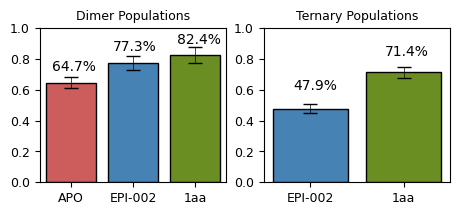

In [13]:
dimer_populations = np.array([block_error(ResidueDistances.load(f'{path}/r1r2_ca_distance_dict.pkl').contacts(1).any(1).astype(int))
                    for path in paths]).T


_, ax = plt.subplots(1, 2,
                     figsize=(5.3, 2), 
                     #dpi=500,
                    )
box_plot(dimer_populations[0],
         errors=dimer_populations[1],
         error_capsize=5, 
         error_linewidth=.5,
         error_capthick=1,
         error_color='black',
         #cmap="coolwarm",
         color_list=['indianred', 'steelblue', 'olivedrab'],
         alpha=1, 
         font_scale=state_font_scale, 
         labels=labels,
         title = 'Dimer Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=0.8,
         ax=ax[0])

ax[0].text(-.3, .72, f'{100 * dimer_populations[0,0] :.1f}%')
ax[0].text(.68, .85, f'{100 * dimer_populations[0,1] :.1f}%')
ax[0].text(1.7, .9, f'{100 * dimer_populations[0,2] :.1f}%')

ternary_populations = np.array([block_error(
    prod([i.any(1) for i in split(to_contacts(np.load(f'{path}/ligand_distances.npy'), 0.6))]))
                    for path in paths[1:]]).T



box_plot(ternary_populations[0],
         errors=ternary_populations[1],
         error_capsize=5,
         error_linewidth=.5,
         error_capthick=1,
         error_color='black',
         #cmap="coolwarm",
         color_list=['steelblue', 'olivedrab'],
         alpha=1, 
         font_scale=state_font_scale, 
         labels=labels[1:],
         title = 'Ternary Populations',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         ymin=0,
         ymax=1,
         width=0.8,
         ax=ax[1])

ax[1].text(-.18, .6, f'{100 * ternary_populations[0,0] :.1f}%')
ax[1].text(.8, .82, f'{100 * ternary_populations[0,1] :.1f}%')

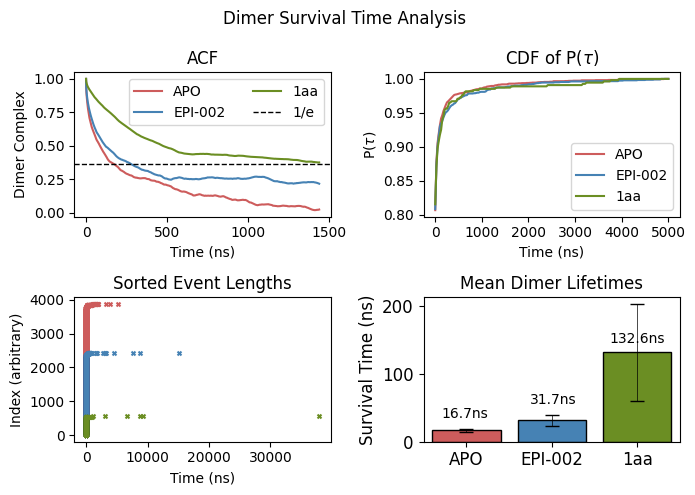

In [206]:
from writhe_tools.stats import acf
fig, axes = plt.subplots(2, 2, figsize=(7, 5))
axes = axes.flat
ax = axes
average_dimer = []
#tau=[]
longest_dimer_event = []
longest_dimer_events = []
lengths = []
for path, color, label in zip(paths,
                              ['indianred', 'steelblue', 'olivedrab'],
                             labels):
    
    # any residue - residue CA atom distance less than 1 nm 
    dimer = ResidueDistances.load(f'{path}/r1r2_ca_distance_dict.pkl').contacts(1).any(1).astype(int)

    events = contiguous_bool(bools=dimer)

    #event lengths scaled
    lengths = 0.24 * np.fromiter(map(len, events), float)

    longest_dimer_events.append(reindex_list(events, lengths.argsort()[::-1][:10]))

    #bootstrap mean
    average_dimer.append(list(bootstrap(lengths, n_resamples=5000)))

    
    longest_dimer_event.append(get_longest_event(dimer))
    # have to bootstrap the lengths because it's not a time continuous measurement (block error doesn't make sense here)
    # inverse FFT for the ACF on binary array
    ac = acf(dimer)
    #get the correlation time
    #tau.append(get_tau(ac))
    axes[0].plot(np.arange(0, 6000) * 0.24,  # scale the time
                 ac[:6000],
                 c=color,
                 label=label,
                )
    bins=200
    axes[1].plot( np.linspace(0, 5000, bins), np.cumsum(pmf(np.sort(lengths), bins=bins, range=(0,500))[0]), label=label, c=color)
    axes[2].scatter(np.sort(lengths), np.arange(len(lengths)), label=label, c=color, s=8, marker='x')
    #box_plot(pmf(np.sort(lengths), bins=4, range=(0,30000), norm=False)[0], label=label, ax=axes[2])



axes[2].set_xlabel('Time (ns)')
axes[2].set_ylabel('Index (arbitrary)')
axes[2].set_title('Sorted Event Lengths')

axes[1].set_ylabel(r'P($\tau$)')
axes[1].set_xlabel('Time (ns)')
axes[1].legend()
axes[1].set_title('CDF of ' + r'P($\tau$)')

axes[0].axhline(y=1/np.exp(1),
                linestyle='--',
                color='black',
                linewidth=1,
                label='1/e',
               )

axes[0].set_xlabel(r"Time (ns)")
axes[0].set_ylabel("Dimer Complex")
axes[0].legend(ncol=2)
axes[0].set_title('ACF')

#axes[2].legend()
fig.suptitle('Dimer Survival Time Analysis')




box_plot(np.fromiter((i[0] for i in average_dimer), float),
         errors=np.array([[abs(j - i[0]) for j in i[1]] for i in average_dimer]).T,
         error_capsize=5,
         error_linewidth=.5,
         error_capthick=1,
         error_color='black',
         #cmap="coolwarm",
         color_list=['indianred','steelblue', 'olivedrab'],
         alpha=1, 
         font_scale=2, 
         labels=labels,
         title = 'Mean Dimer Lifetimes',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         width=0.8,
         ax=ax[3])

ax[3].set_ylabel("Survival Time (ns)")

ax[3].text(-.29, 35, f'{average_dimer[0][0] :.1f}ns')
ax[3].text(.74, 55, f'{average_dimer[1][0] :.1f}ns')
ax[3].text(1.68, 146, f'{average_dimer[2][0] :.1f}ns')
fig.tight_layout()

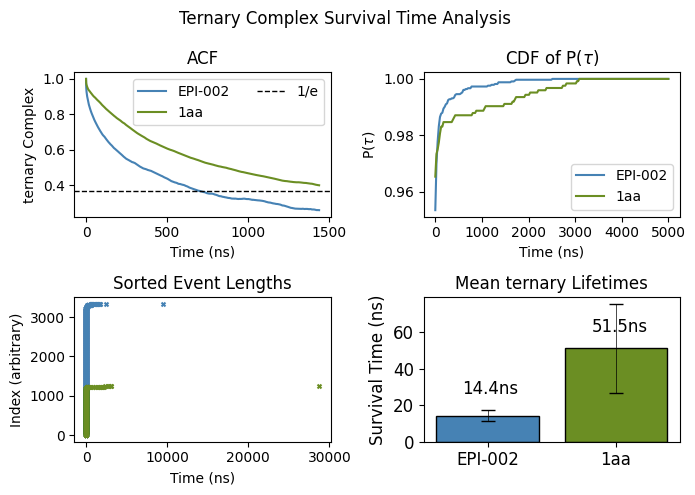

In [207]:
fig, axes = plt.subplots(2, 2, figsize=(7, 5))
axes = axes.flat
ax = axes
average_ternary = []
#tau=[]
longest_ternary_event = []
longest_ternary_events = []
lengths = []
for path, color, label in zip(paths[1:],
                              [ 'steelblue', 'olivedrab'],
                             labels[1:]):
    
    # any residue - residue CA atom distance less than 1 nm 
    ternary = prod([i.any(1) for i in split(to_contacts(np.load(f'{path}/ligand_distances.npy'), 0.6))])

    events = contiguous_bool(bools=ternary)

    #event lengths scaled
    lengths = 0.24 * np.fromiter(map(len, events), float)

    longest_ternary_events.append(reindex_list(events, lengths.argsort()[::-1][:10]))

    #bootstrap mean
    average_ternary.append(list(bootstrap(lengths, n_resamples=5000)))

    
    longest_ternary_event.append(get_longest_event(ternary))
    # have to bootstrap the lengths because it's not a time continuous measurement (block error doesn't make sense here)
    # inverse FFT for the ACF on binary array
    ac = acf(ternary)
    #get the correlation time
    #tau.append(get_tau(ac))
    axes[0].plot(np.arange(0, 6000) * 0.24,  # scale the time
                 ac[:6000],
                 c=color,
                 label=label,
                )
    bins=200
    axes[1].plot( np.linspace(0, 5000, bins), np.cumsum(pmf(np.sort(lengths), bins=bins, range=(0,5000))[0]), label=label, c=color)
    axes[2].scatter(np.sort(lengths), np.arange(len(lengths)), label=label, c=color, s=8, marker='x')
    #box_plot(pmf(np.sort(lengths), bins=4, range=(0,30000), norm=False)[0], label=label, ax=axes[2])



axes[2].set_xlabel('Time (ns)')
axes[2].set_ylabel('Index (arbitrary)')
axes[2].set_title('Sorted Event Lengths')

axes[1].set_ylabel(r'P($\tau$)')
axes[1].set_xlabel('Time (ns)')
axes[1].legend()
axes[1].set_title('CDF of ' + r'P($\tau$)')

axes[0].axhline(y=1/np.exp(1),
                linestyle='--',
                color='black',
                linewidth=1,
                label='1/e',
               )

axes[0].set_xlabel(r"Time (ns)")
axes[0].set_ylabel("ternary Complex")
axes[0].legend(ncol=2)
axes[0].set_title('ACF')

#axes[2].legend()
fig.suptitle('Ternary Complex Survival Time Analysis')




box_plot(np.fromiter((i[0] for i in average_ternary), float),
         errors=np.array([[abs(j - i[0]) for j in i[1]] for i in average_ternary]).T,
         error_capsize=5,
         error_linewidth=.5,
         error_capthick=1,
         error_color='black',
         #cmap="coolwarm",
         color_list=['steelblue', 'olivedrab'],
         alpha=1, 
         font_scale=2, 
         labels=labels[1:],
         title = 'Mean ternary Lifetimes',
         rotation=0,
         trunc=trunc,
         pre_trunc=pre_trunc,
         width=0.8,
         ax=ax[3])

ax[3].set_ylabel("Survival Time (ns)")

ax[3].text(-.2, 26, f'{average_ternary[0][0] :.1f}ns', size=12)
ax[3].text(.81, 60, f'{average_ternary[1][0] :.1f}ns',size=12)
#ax[3].text(1.6, 144, f'{average_[2][0] :.1f}ns')
fig.tight_layout()

# Longest Event Analysis

9
10
7
9
10


Text(0.5, -0.3, 'Writhe tCCA Cluster Index')

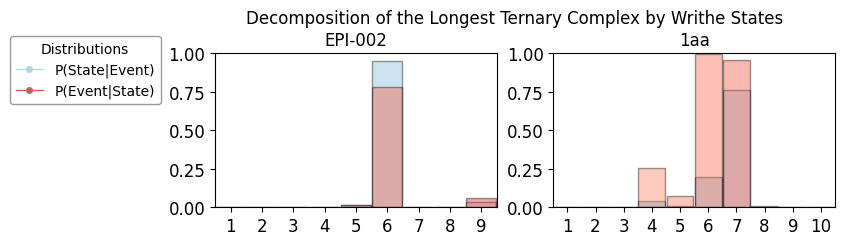

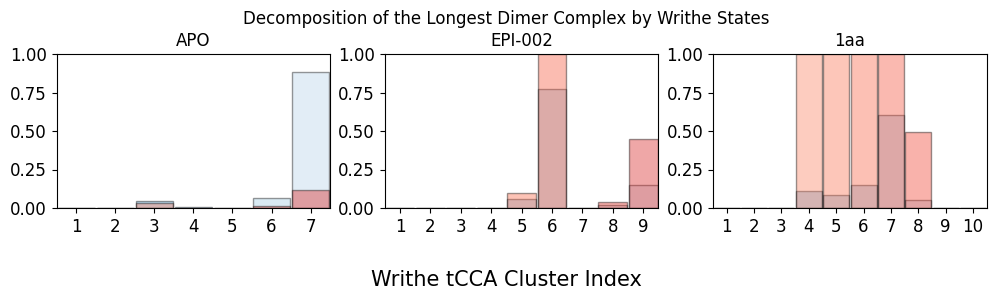

In [211]:
fig, axes = plt.subplots(1, 2, figsize=(8, 2))
for i, (ax, frames, dtraj, label) in enumerate(zip(axes.flat,
                                                   [i[0] for i in  longest_ternary_events],
                                                   macro_states[1:],
                                                   labels[1:])):
    print(np.unique(dtraj).size)
    cSE = pmf(dtraj[frames], np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    cS =  pmf(dtraj, np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    pES = cSE / cS
    pSE = cSE / cSE.sum()
    
    box_plot(pSE, label_stride=1, cmap='Blues_r',
             ax=ax, alpha=.4, labels=np.arange(len(pES))+1,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(pES, label_stride=1, cmap='Reds',
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Populaton", 
             labels=np.arange(len(pES))+1, title = label,
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=l,
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, (l, color) in enumerate(zip(["P(State|Event)", "P(Event|State)"],
                                                 ["lightblue", "indianred"]))]
    
fig.legend(handles=legend_elements,title="Distributions",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=1,
           bbox_to_anchor = [-.14,1])

fig.suptitle("Decomposition of the Longest Ternary Complex by Writhe States", y=1.1)


fig, axes = plt.subplots(1, 3, figsize=(12, 2))
for i, (ax, frames, dtraj, label) in enumerate(zip(axes.flat,
                                                   [i[0] for i in longest_dimer_events],
                                                   macro_states,
                                                   labels)):
    print(np.unique(dtraj).size)
    cSE = pmf(dtraj[frames], np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    cS =  pmf(dtraj, np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    pES = cSE / cS
    pSE = cSE / cSE.sum()
    
    box_plot(pSE, label_stride=1, cmap='Blues_r',
             ax=ax, alpha=.4, labels=np.arange(len(pES))+1,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(pES, label_stride=1, cmap='Reds',
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Populaton", 
             labels=np.arange(len(pES))+1, title = label,
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=l,
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, (l, color) in enumerate(zip(["P(State|Event)", "P(Event|State)"],
                                                 ["lightblue", "indianred"]))]
    
# fig.legend(handles=legend_elements,title="Distributions",loc="upper left",
#            fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=1,
#            bbox_to_anchor = [.9,1])

fig.suptitle("Decomposition of the Longest Dimer Complex by Writhe States", y=1.1)
fig.supxlabel('Writhe tCCA Cluster Index', y=-0.3, size=15)

9
10
7
9
10


Text(0.5, -0.3, 'Writhe tCCA Cluster Index')

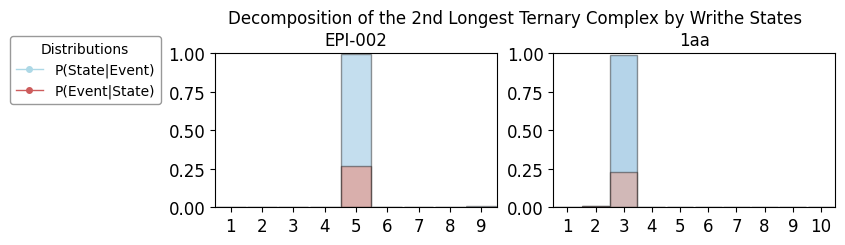

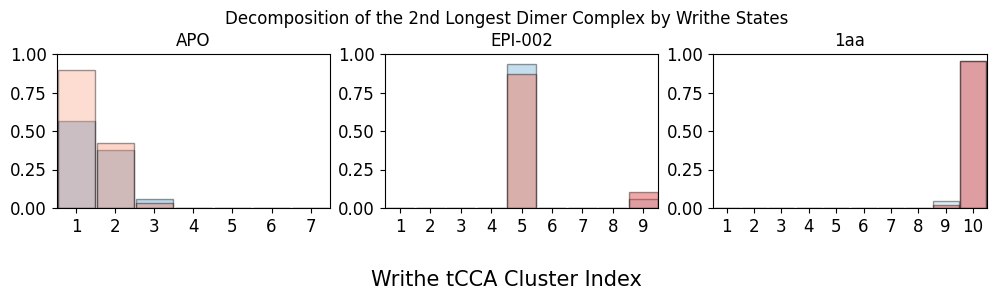

In [212]:
fig, axes = plt.subplots(1, 2, figsize=(8, 2))
for i, (ax, frames, dtraj, label) in enumerate(zip(axes.flat,
                                                   [i[1] for i in  longest_ternary_events],
                                                   macro_states[1:],
                                                   labels[1:])):
    print(np.unique(dtraj).size)
    cSE = pmf(dtraj[frames], np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    cS =  pmf(dtraj, np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    pES = cSE / cS
    pSE = cSE / cSE.sum()
    
    box_plot(pSE, label_stride=1, cmap='Blues_r',
             ax=ax, alpha=.4, labels=np.arange(len(pES))+1,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(pES, label_stride=1, cmap='Reds',
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Populaton", 
             labels=np.arange(len(pES))+1, title = label,
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=l,
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, (l, color) in enumerate(zip(["P(State|Event)", "P(Event|State)"],
                                                 ["lightblue", "indianred"]))]
    
fig.legend(handles=legend_elements,title="Distributions",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=1,
           bbox_to_anchor = [-.14,1])

fig.suptitle("Decomposition of the 2nd Longest Ternary Complex by Writhe States", y=1.1)


fig, axes = plt.subplots(1, 3, figsize=(12, 2))
for i, (ax, frames, dtraj, label) in enumerate(zip(axes.flat,
                                                   [i[1] for i in longest_dimer_events],
                                                   macro_states,
                                                   labels)):
    print(np.unique(dtraj).size)
    cSE = pmf(dtraj[frames], np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    cS =  pmf(dtraj, np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    pES = cSE / cS
    pSE = cSE / cSE.sum()
    
    box_plot(pSE, label_stride=1, cmap='Blues_r',
             ax=ax, alpha=.4, labels=np.arange(len(pES))+1,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(pES, label_stride=1, cmap='Reds',
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Populaton", 
             labels=np.arange(len(pES))+1, title = label,
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=l,
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, (l, color) in enumerate(zip(["P(State|Event)", "P(Event|State)"],
                                                 ["lightblue", "indianred"]))]
    
# fig.legend(handles=legend_elements,title="Distributions",loc="upper left",
#            fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=1,
#            bbox_to_anchor = [.9,1])

fig.suptitle("Decomposition of the 2nd Longest Dimer Complex by Writhe States", y=1.1)
fig.supxlabel('Writhe tCCA Cluster Index', y=-0.3, size=15)

9
10
7
9
10


Text(0.5, -0.3, 'Writhe tCCA Cluster Index')

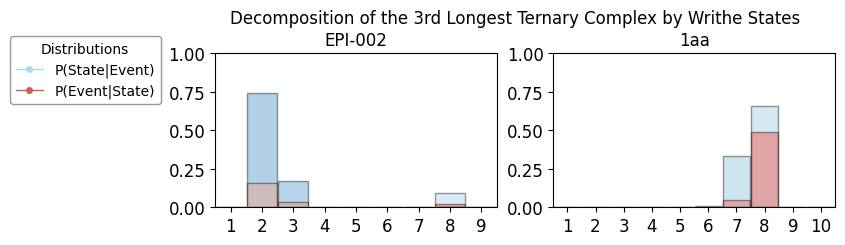

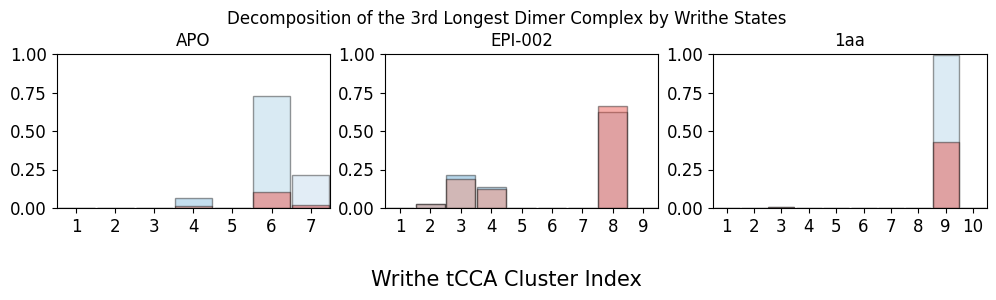

In [314]:
fig, axes = plt.subplots(1, 2, figsize=(8, 2))
for i, (ax, frames, dtraj, label) in enumerate(zip(axes.flat,
                                                   [i[2] for i in  longest_ternary_events],
                                                   macro_states[1:],
                                                   labels[1:])):
    print(np.unique(dtraj).size)
    cSE = pmf(dtraj[frames], np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    cS =  pmf(dtraj, np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    pES = cSE / cS
    pSE = cSE / cSE.sum()
    
    box_plot(pSE, label_stride=1, cmap='Blues_r',
             ax=ax, alpha=.4, labels=np.arange(len(pES))+1,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(pES, label_stride=1, cmap='Reds',
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Populaton", 
             labels=np.arange(len(pES))+1, title = label,
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=l,
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, (l, color) in enumerate(zip(["P(State|Event)", "P(Event|State)"],
                                                 ["lightblue", "indianred"]))]
    
fig.legend(handles=legend_elements,title="Distributions",loc="upper left",
           fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=1,
           bbox_to_anchor = [-.14,1])

fig.suptitle("Decomposition of the 3rd Longest Ternary Complex by Writhe States", y=1.1)


fig, axes = plt.subplots(1, 3, figsize=(12, 2))
for i, (ax, frames, dtraj, label) in enumerate(zip(axes.flat,
                                                   [i[2] for i in longest_dimer_events],
                                                   macro_states,
                                                   labels)):
    print(np.unique(dtraj).size)
    cSE = pmf(dtraj[frames], np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    cS =  pmf(dtraj, np.unique(dtraj).size, norm=False, range=(0, np.unique(dtraj).size,))[0]
    pES = cSE / cS
    pSE = cSE / cSE.sum()
    
    box_plot(pSE, label_stride=1, cmap='Blues_r',
             ax=ax, alpha=.4, labels=np.arange(len(pES))+1,
             font_scale=2, trunc=trunc, pre_trunc=pre_trunc)

    box_plot(pES, label_stride=1, cmap='Reds',
             ax=ax, alpha=.4, font_scale=2,#ylabel="Contact\n Populaton", 
             labels=np.arange(len(pES))+1, title = label,
             rotation=0, trunc=trunc, pre_trunc=pre_trunc, ymin=0, ymax=1)

    legend_elements = [Line2D([0], [0],
                              marker="o", 
                              color=color,
                              label=l,
                              markerfacecolor=color,
                              markersize=4,
                              lw=1)
                       for i, (l, color) in enumerate(zip(["P(State|Event)", "P(Event|State)"],
                                                 ["lightblue", "indianred"]))]
    
# fig.legend(handles=legend_elements,title="Distributions",loc="upper left",
#            fontsize=10, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=1,
#            bbox_to_anchor = [.9,1])

fig.suptitle("Decomposition of the 3rd Longest Dimer Complex by Writhe States", y=1.1)
fig.supxlabel('Writhe tCCA Cluster Index', y=-0.3, size=15)

 # return back to the tCCA state decompositions to see analysis of the longest lived dimer and ternary complexes

# Writhe tCCA Latent Space Analysis

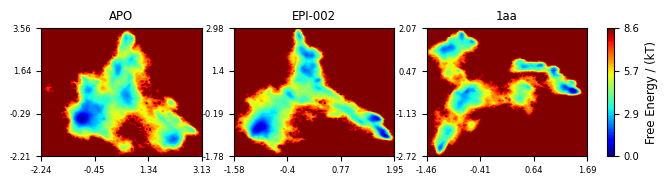

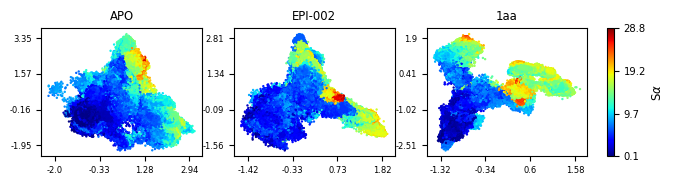

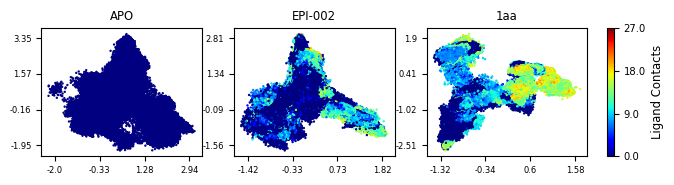

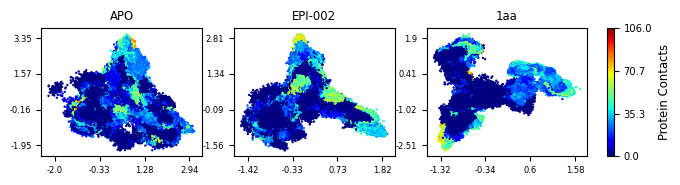

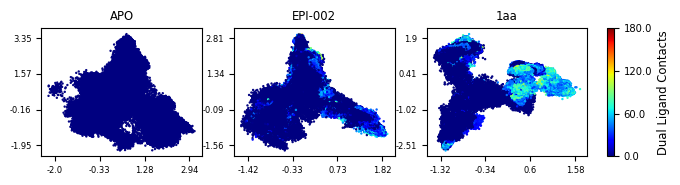

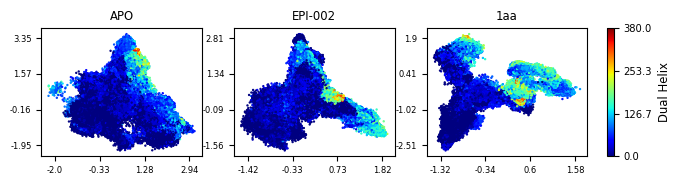

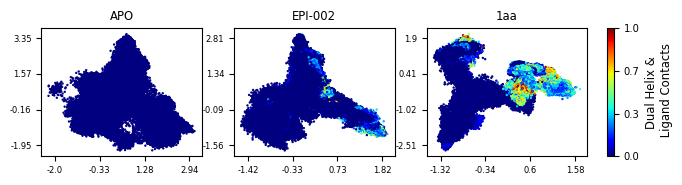

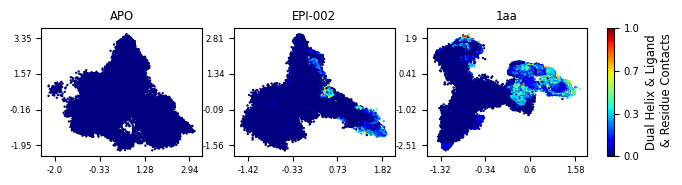

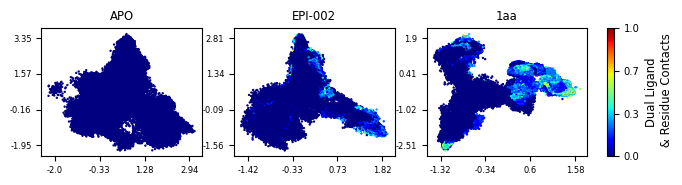

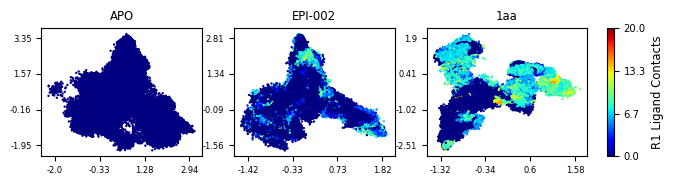

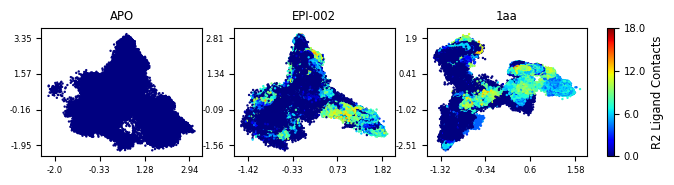

In [103]:

dot_size = 0.0001



subplots_fes2d([i[:, :2] for i in projs], 1, 3, labels, figsize=(7.2, 2), share_extent=False)

subplots_proj2d([i[1:, :2] for i in projs],
                [np.load(f'{path}/r1r2_sa.npy').sum(-1) for path in paths],
                1, 3, labels,
                figsize=(7.2, 2 ),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= r"S$\alpha$")


subplots_proj2d([i[1:, :2] for i in projs],
                [to_contacts(np.load(f'{path}/ligand_distances.npy')).sum(-1)
                 for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "Ligand Contacts",
)

subplots_proj2d([i[1:, :2] for i in projs],
                [ResidueDistances.load(path).contacts(.6).sum(-1)
                 for path in r1r2_distance_paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "Protein Contacts")

subplots_proj2d([i[1:, :2] for i in projs],
                [product(split(to_contacts(np.load(f'{path}/ligand_distances.npy'))), sum_=True)
                 for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "Dual Ligand Contacts",
)



subplots_proj2d([i[1:, :2] for i in projs],
                [product(split(np.load(f'{path}/dsspH.npy')), sum_=True) for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                #vmax=70,
                cbar_label= "Dual Helix",
)

from itertools import chain
subplots_proj2d([i[1:, :2] for i in projs],
                ligand_helix,
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                #vmax=70,
                cbar_label= "Dual Helix &\n Ligand Contacts",
)

subplots_proj2d([i[1:, :2] for i in projs],
                protein_ligand_helix,
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                #vmax=0.6,
                cbar_label= "Dual Helix & Ligand\n & Residue Contacts",
)

subplots_proj2d([i[1:, :2] for i in projs],
                protein_ligand,
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                #vmax=0.6,
                cbar_label= "Dual Ligand\n & Residue Contacts",
)



subplots_proj2d([i[1:, :2] for i in projs],
                [to_contacts(np.load(f'{path}/ligand_distances.npy')[:, :24]).sum(-1)
                 for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "R1 Ligand Contacts")

subplots_proj2d([i[1:, :2] for i in projs],
                [to_contacts(np.load(f'{path}/ligand_distances.npy')[:, 24:]).sum(-1)
                 for path in paths],
                1, 3, labels,
                figsize=(7.2, 2),
                share_extent=False,
                dot_size=dot_size,
                cbar_label= "R2 Ligand Contacts")


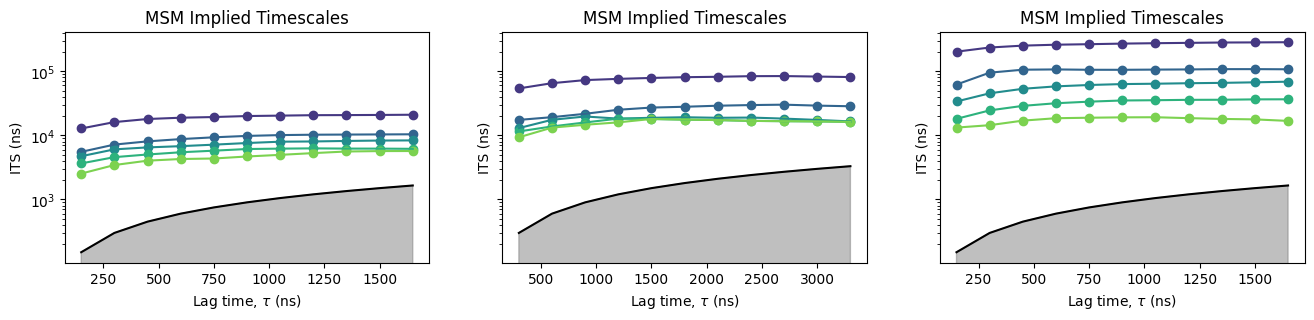

In [59]:
msms = [MarkovModel(i).estimate_msm(lag, 10, reversible=False) for i, lag in zip(micro_states, (150, 300, 150))]
fig, axes = plt.subplots(1, 3, figsize=(16, 3), sharey=True)
for model, ax, label in zip(msms, axes.flat, labels):
    model.its('msm', ax=ax, n_its=5)

In [60]:
assignments = [pairwise_distances_argmin(micro, macro) for micro, macro in zip(micro_centroids, macro_centroids)]
sets = [group_by(i) for i in assignments]

In [76]:
import deeptime
def mfpt_mat(tmat, states, dt=1, lag=1, mu=None):
    nstates = len(states)
    mfpt = np.zeros((nstates, nstates))
    for i, s0 in enumerate(states):
        for j, s1 in enumerate(states):
            mfpt[i, j] = deeptime.markov.tools.analysis.mfpt(tmat, s0, s1)
    return mfpt * dt * lag

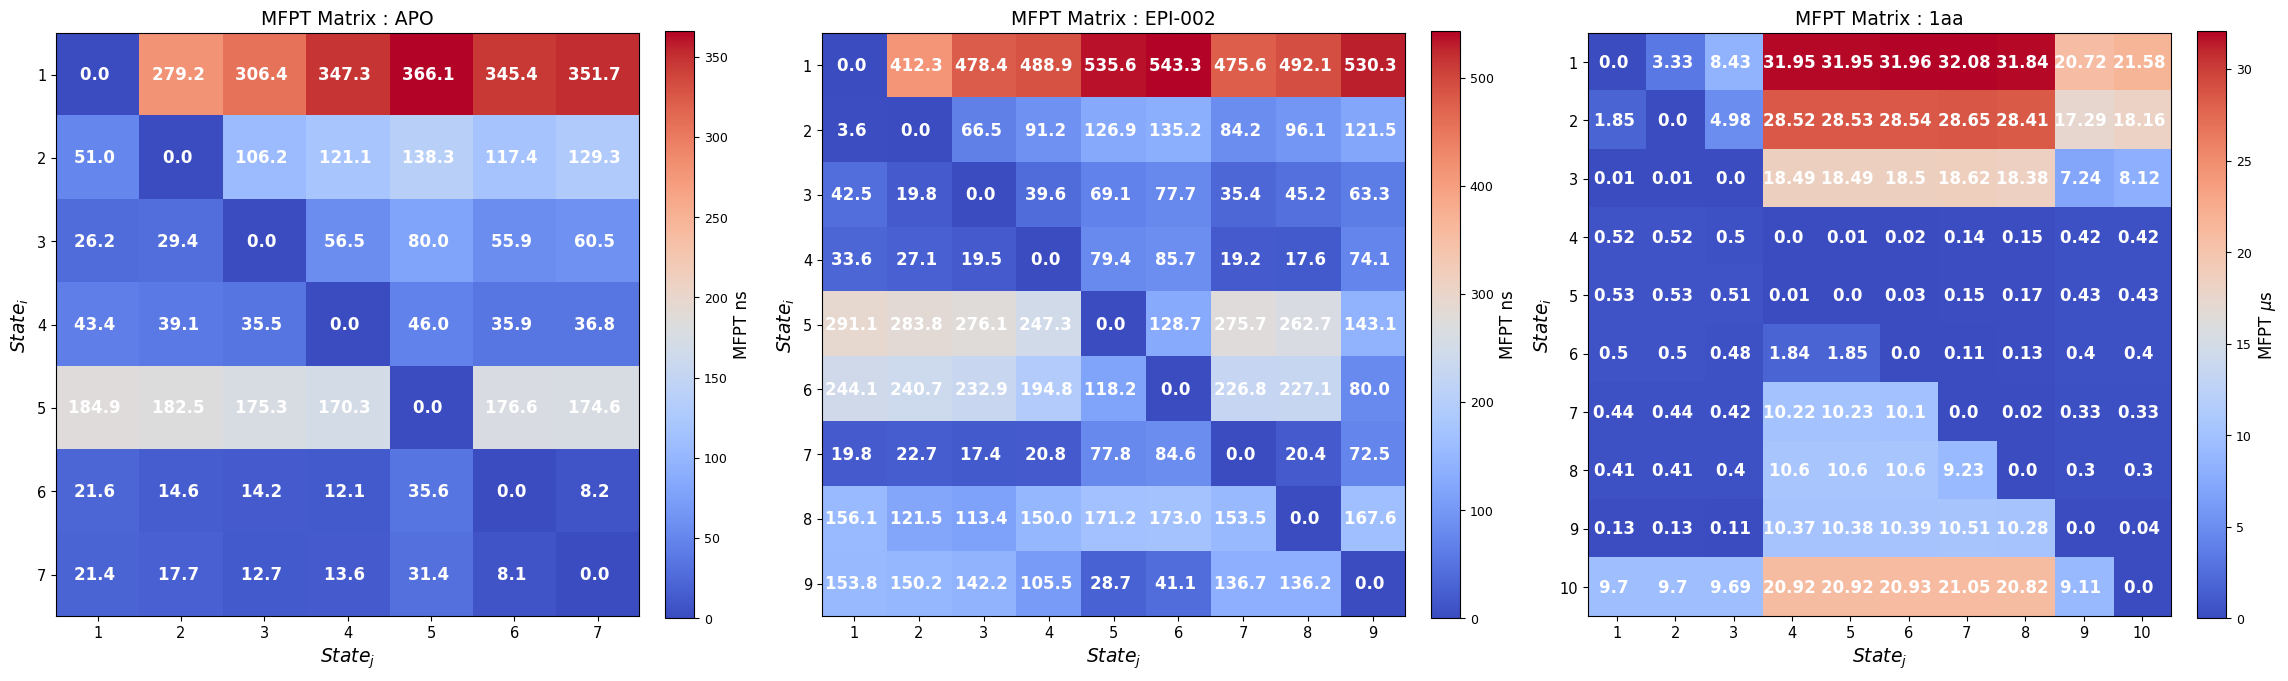

In [141]:
from writhe_tools.plots import annotated_matrix_plot
fig, axes = plt.subplots(1, 3, figsize=(28, 10))
for tmat, s, label, ax,unit, deci, unit_name in zip(tmats, sets, labels, axes.flat, (1, 1, 1e-3), (1, 1, 2),
                                                   ('ns', 'ns', r'$\mu$s')
                                                   ):
    
    annotated_matrix_plot(mfpt_mat(tmat, s) * unit, decimals=deci, cmap='coolwarm', 
                          title = f'MFPT Matrix : {label}',ax=ax,
                          font_scale=.3, cbar_label=f'MFPT {unit_name}'
                          )

In [485]:
"""PBCdisplacements — fast broadcasted PBC‑aware displacements
===========================================================
Single utility that converts *wrapped* coordinates `(N, d, 3)` into the exact
*unwrapped* displacement vectors for a list of index pairs — all without ever
materialising an unwrapped trajectory.

Key features
------------
* **Backend‑agnostic**: NumPy (optionally Ray‑parallel) *or* Torch (JIT, GPU).
* **Memory‑frugal**  : reuses buffers, builds lattice‑shift `n` lazily and only
  for requested samples.
* **Broadcast‑first**: outputs `(N_samples, M_pairs, 3)` in one go.
* **One‑shot API**   : `PBCdisplacements.compute(...)` for stateless usage.

Example
-------
```python
Δ = PBCdisplacements.compute(
        coords, box_lengths, pairs,          # mandatory
        backend="auto", use_ray=True        # optional speed knobs
)
```

Implementation
--------------
"""
from __future__ import annotations
import numpy as np
from typing import Sequence, Union, Optional

# Optional acceleration libraries ------------------------------------------------
try:
    import ray
    _RAY = True
except ModuleNotFoundError:
    _RAY = False

try:
    import torch
    _TORCH = True
except ModuleNotFoundError:
    _TORCH = False

# ------------------------------------------------------------------------------
# Low‑level helpers: NumPy (single sample)
# ------------------------------------------------------------------------------

def _shift_numpy_sample(coords: np.ndarray, box: np.ndarray) -> np.ndarray:
    """Return lattice‑shift field n_i for one sample (d,3)."""
    d = coords.shape[0]
    n = np.empty((d, 3), dtype=np.int64)
    n[0] = 0
    diff = coords[1:] - coords[:-1]
    shift = np.rint(diff / box).astype(np.int64, copy=False)  # −1/0/1
    np.cumsum(shift, axis=0, out=n[1:])
    return n

if _RAY:
    @ray.remote
    def _shift_numpy_sample_remote(coords: np.ndarray, box: np.ndarray):
        return _shift_numpy_sample(coords, box)

# ------------------------------------------------------------------------------
# Low‑level helpers: Torch (single sample)
# ------------------------------------------------------------------------------
if _TORCH:

    @torch.jit.script
    def _shift_torch_sample(coords: torch.Tensor, box: torch.Tensor):
        d = coords.size(0)
        n = torch.zeros((d, 3), dtype=torch.int64, device=coords.device)
        diff = coords[1:] - coords[:-1]
        shift = torch.round(diff / box).to(torch.int64)
        n[1:] = torch.cumsum(shift, dim=0)
        return n

    @torch.jit.script
    def _disp_pairs_torch(pairs: torch.Tensor,
                          coords: torch.Tensor,
                          shifts: torch.Tensor,
                          box: torch.Tensor):
        raw = coords[:, pairs[:, 1]] - coords[:, pairs[:, 0]]
        lat = (shifts[:, pairs[:, 1]] - shifts[:, pairs[:, 0]]) * box.unsqueeze(1)
        return raw + lat

# ------------------------------------------------------------------------------
# Main class
# ------------------------------------------------------------------------------
class PBCdisplacements:
    """Fast PBC displacement calculator with both OO and one‑shot APIs."""

    # ------------------------------------------------------------------
    # constructor -------------------------------------------------------
    # ------------------------------------------------------------------
    def __init__(self,
                 coords: Union[np.ndarray, 'torch.Tensor'],
                 box:   Union[np.ndarray, 'torch.Tensor', Sequence[float]],
                 *,
                 backend: str = 'auto',
                 use_ray: bool = False):
        # backend choice
        if backend == 'auto':
            backend = 'torch' if _TORCH and isinstance(coords, torch.Tensor) else 'numpy'
        self.backend = backend

        if backend == 'numpy':
            if not isinstance(coords, np.ndarray):
                raise TypeError('NumPy backend expects numpy.ndarray coords')
            self.p = coords.astype(np.float64, copy=False)
            self.box = np.asarray(box, dtype=np.float64)
            if self.box.ndim == 1:
                self.box = np.broadcast_to(self.box, (self.p.shape[0], 3))
            self._use_ray = bool(use_ray and _RAY)
        else:
            if not (_TORCH and isinstance(coords, torch.Tensor)):
                raise TypeError('Torch backend expects torch.Tensor coords')
            self.p = coords
            self.box = torch.as_tensor(box, dtype=self.p.dtype, device=self.p.device)
            if self.box.ndim == 1:
                self.box = self.box.expand(self.p.size(0), 3)
        self.n = None  # shift field

    # ------------------------------------------------------------------
    # build_shifts ------------------------------------------------------
    # ------------------------------------------------------------------
    def build_shifts(self, sample_index: Optional[Sequence[int]] = None):
        if sample_index is None:
            sample_index = range(self.p.shape[0])

        if self.backend == 'numpy':
            N, d = self.p.shape[:2]
            n_all = np.zeros((N, d, 3), dtype=np.int64)
            if self._use_ray and len(sample_index) > 1:
                if not ray.is_initialized():
                    ray.init(ignore_reinit_error=True, log_to_driver=False)
                fut = [_shift_numpy_sample_remote.remote(self.p[s], self.box[s]) for s in sample_index]
                for s, res in zip(sample_index, ray.get(fut)):
                    n_all[s] = res
            else:
                for s in sample_index:
                    n_all[s] = _shift_numpy_sample(self.p[s], self.box[s])
            self.n = n_all
        else:
            N, d = self.p.size()[:2]
            n_all = torch.zeros((N, d, 3), dtype=torch.int64, device=self.p.device)
            for s in sample_index:
                n_all[s] = _shift_torch_sample(self.p[s], self.box[s])
            self.n = n_all

    # ------------------------------------------------------------------
    # callable: return displacements -----------------------------------
    # ------------------------------------------------------------------
    def __call__(self,
                 pairs: Union[Sequence[int], np.ndarray, 'torch.Tensor'],
                 *,
                 sample_index: Optional[Sequence[int]] = None,
                 as_numpy: Optional[bool] = None):
        if self.n is None:
            self.build_shifts(sample_index)
        if sample_index is None:
            idx = slice(None)
        else:
            idx = (np.asarray(sample_index, dtype=int)
                   if self.backend == 'numpy'
                   else torch.as_tensor(sample_index, dtype=torch.long, device=self.p.device))

        if self.backend == 'numpy':
            pairs = np.asarray(pairs, dtype=np.int64)
            raw = self.p[idx][:, pairs[:, 1]] - self.p[idx][:, pairs[:, 0]]
            lat = (self.n[idx][:, pairs[:, 1]] - self.n[idx][:, pairs[:, 0]]) * self.box[idx][:, None, :]
            disp = raw + lat
            if as_numpy is False:
                disp = torch.from_numpy(disp)
            return disp
        else:
            pairs_t = torch.as_tensor(pairs, dtype=torch.long, device=self.p.device)
            disp = _disp_pairs_torch(pairs_t, self.p[idx], self.n[idx], self.box[idx])
            if as_numpy or (as_numpy is None and self.backend == 'numpy'):
                disp = disp.cpu().numpy()
            return disp

    # ------------------------------------------------------------------
    # classmethod: **one‑shot** API ------------------------------------
    # ------------------------------------------------------------------
    @classmethod
    def compute(cls,
                coords: Union[np.ndarray, 'torch.Tensor'],
                box:    Union[np.ndarray, 'torch.Tensor', Sequence[float]],
                pairs:  Union[Sequence[int], np.ndarray, 'torch.Tensor'],
                *,
                backend: str = 'auto',
                use_ray: bool = False,
                sample_index: Optional[Sequence[int]] = None,
                as_numpy: Optional[bool] = None):
        """Stateless helper: do everything in one call.

        Returns `(Nsamples, M_pairs, 3)` displacement tensor/array.
        """
        obj = cls(coords, box, backend=backend, use_ray=use_ray)
        obj.build_shifts(sample_index)
        return obj(pairs, sample_index=sample_index, as_numpy=as_numpy)

# ------------------------------------------------------------------------------
# (Optional) Stubs for future C/C++ backends: plug‑replace _shift_numpy_sample
# ------------------------------------------------------------------------------


 ## We can also do sanity checks on the distances / writhe calculations by considering the distance between adjacent CA atoms in sequence. These values show be between ~ 3.4-4.3 Angstrom. Here, I'll compute them without any periodic boundary consideration - if this works, it suggests that the proteins in the data file are whole.

In [706]:
from writhe_tools.utils import product, shifted_pairs
for i, label in enumerate(labels):
    traj = md.load(protein_files[i],
                   top=protein_pdb,
                   atom_indices=md.load(protein_pdb).top.select('name CA'),
                   stride = 10).center_coordinates()
    
    for j, selection in enumerate(((0, 24), (24, 48))):  
        pairs = shifted_pairs(np.arange(*selection), 1)
        chain_distances = np.linalg.norm(traj.xyz[:, pairs.T[0]] - traj.xyz[:, pairs.T[1]], axis=-1)
        print(f'Adjacent CA distances R{j+1} : {label} (min/max) : {get_extrema(chain_distances.flatten())}')
    
    

Adjacent CA distances R1 : APO (min/max) : [0.35780832171440125, 0.411579966545105]
Adjacent CA distances R2 : APO (min/max) : [0.358946293592453, 0.413178026676178]
Adjacent CA distances R1 : EPI-002 (min/max) : [0.35736244916915894, 0.41257914900779724]
Adjacent CA distances R2 : EPI-002 (min/max) : [0.3561232388019562, 0.4132431447505951]
Adjacent CA distances R1 : 1aa (min/max) : [0.35479632019996643, 0.4132084846496582]
Adjacent CA distances R2 : 1aa (min/max) : [0.3578614294528961, 0.4135800898075104]


 # 'Proton Density' (proton - proton coordination numbers)

In [26]:
import mdtraj as md

def get_non_exchangeable_protons(traj):
    """
    Return indices of all hydrogen atoms bound to carbon atoms (non-exchangeable protons)
    in a given MDTraj trajectory or topology.

    Parameters:
    -----------
    traj : md.Trajectory or md.Topology

    Returns:
    --------
    List of atom indices (integers)
    """
    # Get topology
    top = traj.topology if isinstance(traj, md.Trajectory) else traj

    non_exchangeable = []

    for atom in top.atoms:
        if atom.element.symbol == 'H':
            # Iterate over all bonds in the topology
            for bond in top.bonds:
                a1, a2 = bond
                if atom in bond:
                    other = a2 if atom == a1 else a1
                    if other.element.symbol == 'C':
                        non_exchangeable.append(atom.index)
                    break  # Done once we find its bond
    return np.array(non_exchangeable, dtype=int)

# Protein only trajectories should have the same exact atoms - selections can be made a priori

In [57]:
pdb = md.load(protein_pdb)
sequence, ca_index = get_residues(pdb)
resnames = sequence[ca_index]
non_exchangeable = get_non_exchangeable_protons(pdb)

# now work on the non-exchange-able hydrogen version of the trajectory
# note that indices will now be changed - some linkers don't have any such hydrogens
# so, new indices must be generated
trajH = pdb.atom_slice(non_exchangeable)
residuesH = get_residues(trajH)[0]
residue_index = np.where(np.isin(residuesH, resnames))[0]
monomer_h_indices = [trajH.top.select(' or '.join([f'resid {i}' for i in j])) for j in np.array_split(residue_index, 2)]

In [63]:
noe_contacts = []
for file in protein_files:
    # get full trajectory sequence information
    # slice trajectory into non-exchange-able 
    traj = md.load(file,
                   top=protein_pdb,
                   atom_indices=non_exchangeable,
                   stride = 1)
    
    # get the index of the target atoms - a set for each monomer
    targets = np.array_split(np.array([traj.top.select(f'resid {i} and name HD1')
               for i in np.array([i for i, j in enumerate(residuesH) if 'TRP' in j])]), 2)
    
    targets = list(map(np.ndarray.flatten, targets))

    distance_pairs = [product(i, j) for i, j in zip(targets, monomer_h_indices[::-1])]

    noe_contacts.append(np.stack([to_contacts(md.compute_distances(traj, pair), 0.6) for pair in distance_pairs]).sum(-1).mean(-1))

In [59]:
from pandas import DataFrame
from IPython.display import display, Markdown
display(Markdown(r'TRP$\delta_{1}$ NOE Contacts'))
display(DataFrame(np.array(noe_contacts), index=labels, columns='R1,R2'.split(',')))

TRP$\delta_{1}$ NOE Contacts

R1        R2
APO      2.420376  2.657083
EPI-002  3.649849  3.654999
1aa      4.713299  2.879519

for j in targets:
    print([traj.top.atom(i) for i in j])

for j in distance_pairs:
    for i in j:
        print((trajH.top.atom(i[0]), trajH.top.atom(i[1])))
    print('\nNext Monomer\n')

In [36]:
noe_contacts = []
for file in protein_files:
    # get full trajectory sequence information
    # slice trajectory into non-exchange-able 
    traj = md.load(file,
                   top=protein_pdb,
                   atom_indices=non_exchangeable,
                   stride = 1)
    
    
    # get the index of the target atoms - a set for each monomer
    targets = np.array_split(np.concatenate([traj.top.select(f'resid {i} and (name HD1 or name HD2)' if 'TYR' in residuesH[i] else
                                                      f'resid {i} and name HZ3') 
                                       for i in np.array([i for i, j in enumerate(residuesH) if ('TRP' in j) or ('TYR' in j)])]),
                             2)
    
    targets = list(map(np.ndarray.flatten, targets))

    distance_pairs = [product(i, j) for i, j in zip(targets, monomer_h_indices[::-1])]

    noe_contacts.append(np.stack([to_contacts(md.compute_distances(traj, pair), 0.6) for pair in distance_pairs]).sum(-1).mean(-1))

In [37]:
from pandas import DataFrame
display(Markdown(r'TYR $Hδ_{1/2}$ or TRP H$ζ_{3}$ : NOE Contacts'))
display(DataFrame(np.array(noe_contacts), index=labels, columns='R1,R2'.split(',')))

TYR $Hδ_{1/2}$ or TRP H$ζ_{3}$ : NOE Contacts

R1         R2
APO      10.272625  11.077802
EPI-002  14.891319  13.201171
1aa      16.797906  19.407342

for j in targets:
    print([traj.top.atom(i) for i in j]) 

for j in distance_pairs:
    for i in j:
        print((trajH.top.atom(i[0]), trajH.top.atom(i[1])))
    print('\nNext Monomer\n')

In [40]:
noe_contacts = []
for file in protein_files:
    # get full trajectory sequence information
    # slice trajectory into non-exchange-able 
    traj = md.load(file,
                   top=protein_pdb,
                   atom_indices=non_exchangeable,
                   stride = 1)
    
    # get the index of the target atoms - a set for each monomer
    targets = np.array_split(np.array([traj.top.select(f'resid {i} and (name HE1 or name HE2)')
               for i in np.array([i for i, j in enumerate(residuesH) if 'TYR' in j])]), 2)
    
    targets = list(map(np.ndarray.flatten, targets))

    distance_pairs = [product(i, j) for i, j in zip(targets, monomer_h_indices[::-1])]

    noe_contacts.append(np.stack([to_contacts(md.compute_distances(traj, pair), 0.6) for pair in distance_pairs]).sum(-1).mean(-1))

In [45]:
from pandas import DataFrame
display(Markdown(r'TYR Hε$_{1/2}$ : NOE Contacts'))
display(DataFrame(np.array(noe_contacts), index=labels, columns='R1,R2'.split(',')))

TYR Hε$_{1/2}$ : NOE Contacts

R1         R2
APO       7.980504   8.680819
EPI-002  11.634666  11.039493
1aa      13.852960  20.767738

In [46]:
for j in targets:
    print([traj.top.atom(i) for i in j]) 

[TYR3-HE1, TYR3-HE2, TYR16-HE1, TYR16-HE2]
[TYR29-HE1, TYR29-HE2, TYR42-HE1, TYR42-HE2]


In [47]:
for j in distance_pairs:
    for i in j:
        print((trajH.top.atom(i[0]), trajH.top.atom(i[1])))
    print('\nNext Monomer\n')

(TYR3-HE1, LEU27-HA)
(TYR3-HE1, LEU27-HB3)
(TYR3-HE1, LEU27-HB2)
(TYR3-HE1, LEU27-HG)
(TYR3-HE1, LEU27-HD11)
(TYR3-HE1, LEU27-HD12)
(TYR3-HE1, LEU27-HD13)
(TYR3-HE1, LEU27-HD21)
(TYR3-HE1, LEU27-HD22)
(TYR3-HE1, LEU27-HD23)
(TYR3-HE1, ASP28-HA)
(TYR3-HE1, ASP28-HB3)
(TYR3-HE1, ASP28-HB2)
(TYR3-HE1, TYR29-HA)
(TYR3-HE1, TYR29-HB3)
(TYR3-HE1, TYR29-HB2)
(TYR3-HE1, TYR29-HD1)
(TYR3-HE1, TYR29-HE1)
(TYR3-HE1, TYR29-HE2)
(TYR3-HE1, TYR29-HD2)
(TYR3-HE1, GLY30-HA3)
(TYR3-HE1, GLY30-HA2)
(TYR3-HE1, SER31-HA)
(TYR3-HE1, SER31-HB3)
(TYR3-HE1, SER31-HB2)
(TYR3-HE1, ALA32-HA)
(TYR3-HE1, ALA32-HB1)
(TYR3-HE1, ALA32-HB2)
(TYR3-HE1, ALA32-HB3)
(TYR3-HE1, TRP33-HA)
(TYR3-HE1, TRP33-HB3)
(TYR3-HE1, TRP33-HB2)
(TYR3-HE1, TRP33-HD1)
(TYR3-HE1, TRP33-HZ2)
(TYR3-HE1, TRP33-HH2)
(TYR3-HE1, TRP33-HZ3)
(TYR3-HE1, TRP33-HE3)
(TYR3-HE1, ALA34-HA)
(TYR3-HE1, ALA34-HB1)
(TYR3-HE1, ALA34-HB2)
(TYR3-HE1, ALA34-HB3)
(TYR3-HE1, ALA35-HA)
(TYR3-HE1, ALA35-HB1)
(TYR3-HE1, ALA35-HB2)
(TYR3-HE1, ALA35-HB3)
(TYR3-HE1, AL

# PBC Corrected Aromatic stacking 

In [642]:
reload(writhe_tools.md_tools)
from writhe_tools.md_tools import canonical_residues

In [690]:
from rdkit import Chem
import tempfile, os
from collections import defaultdict

# ── canonical aromatic rings (6 atoms each) ───────────────────────────────
CANONICAL: Dict[str, List[str]] = {
    "PHE": ["CG", "CD1", "CD2", "CE1", "CE2", "CZ"],
    "TYR": ["CG", "CD1", "CD2", "CE1", "CE2", "CZ"],
    "TRP": ["CD2", "CE2", "CE3", "CD1", "CG", "CZ2"],
    "HIS": ["CG", "ND1", "CD2", "CE1", "NE2"]  # imidazole padded
}

# ── internal helper: RDKit ring detection for one residue slice ───────────
def _rings_from_rdkit_slice(res_traj: md.Trajectory, ring_sizes=(5, 6)) -> List[List[int]]:
    """Return lists of atom indices (wrt slice) that form rings."""
    with tempfile.NamedTemporaryFile(suffix=".pdb", delete=False) as tmp:
        fname = tmp.name
    try:
        res_traj[0].save_pdb(fname, force_overwrite=True)
        mol = Chem.MolFromPDBFile(fname, removeHs=False, sanitize=True)
        if mol is None:
            return []
        rings = []
        for ring in Chem.GetSymmSSSR(mol):
            if len(ring) in ring_sizes:
                rings.append([int(i) for i in ring])
        return rings
    finally:
        os.remove(fname)

# ── main vectorised geometry routine ──────────────────────────────────────
def aromatic_rings(
    traj: md.Trajectory,
    canonical: Dict[str, List[str]] = CANONICAL
) -> Tuple[np.ndarray, np.ndarray, List[Tuple[int, str, List[int]]]]:
    """
    Full pipeline: canonical + RDKit-detected rings → centroids & normals.

    Returns
    -------
    centroids : (n_frames, n_rings, 3)
    normals   : (n_frames, n_rings, 3)
    ring_ids  : list[(res_index, res_name, atom_idx_list)]
    """
    top = traj.topology
    ring_indices: List[List[int]] = []
    ring_ids:     List[Tuple[int, str, List[int]]] = []
    centroids = []
    for res in top.residues:  # zero-indexed by default: res.index
        # --- 1) canonical amino-acid rings --------------------------------
        if res.name in canonical:
            try:
                idx = [res.atom(n).index for n in canonical[res.name]]
                ring_indices.append(idx[:3])
                ring_ids.append((res.index, res.name, idx))
                centroids.append(traj.xyz[:, np.array(idx), :].mean(1))
            except KeyError:
                pass  # skip if atoms missing
            continue  # canonical handled

        # --- 2) non-canonical: RDKit ring detection -----------------------
        res_atoms = [a.index for a in res.atoms]
        if not res_atoms:
            continue
        slice_traj = traj.atom_slice(res_atoms, inplace=False)
        for ring in _rings_from_rdkit_slice(slice_traj):
            full_idx = [res_atoms[i] for i in ring]
            centroids.append(traj.xyz[:, np.array(full_idx), :].mean(1))
            ring_indices.append(full_idx[:3])
            ring_ids.append((res.index, res.name, full_idx))

    if not ring_indices:
        raise ValueError("No aromatic or ligand rings detected.")

    ring_indices = np.asarray(ring_indices)               # (r,6)
    xyz  = traj.xyz[:, ring_indices, :]                   # (f,r,6,3)
    box  = traj.unitcell_lengths[:, None, :]              # (f,1,3)

    # centroids
    centroids = np.stack(centroids, 1)                         # (f,r,3)

    # minimum-image displacement vectors
    v1 = xyz[:, :, 1] - xyz[:, :, 0]
    v2 = xyz[:, :, 2] - xyz[:, :, 0]
    v1 -= box * np.round(v1 / box)
    v2 -= box * np.round(v2 / box)

    return centroids, divnorm(np.cross(v1, v2)), ring_ids

from writhe_tools.md_tools import parallel_displacements, parallel_distances
from writhe_tools.writhe_ray import divnorm

wrap_angle = lambda theta: np.minimum(theta, np.pi - theta)

rm_index = lambda x : np.array(list(map(partial(num_str, reverse=True), x))) 

isin_index = lambda x, y : np.where(np.isin(x, y))[0]


def aro_angles(pairs, centers, normals,  unitcell_lengths):
    displacements = parallel_displacements(centers, pairs, unitcell_lengths)
    distances = np.linalg.norm(displacements, axis=-1, keepdims=True)
    displacements /= distances
    theta = np.arccos(np.sum(normals[:, pairs.T[0]] * normals[:, pairs.T[1]], axis=-1))
    phi = np.arccos(np.sum(displacements[:, pairs.T[0]] * normals[:, pairs.T[1]], axis=-1))
    return *[wrap_angle(i) for i in (theta, phi)], distances.squeeze()

# corrected cutoffs - previous misses T stacks with probability 1/2

def t_stack(theta, phi, distance):
    return (theta > (5 / 12) * np.pi) & ((phi > np.pi / 3) | (phi < np.pi / 6)) & (distance < 0.75)

def pi_stack(theta, phi, distance):
    return (theta < np.pi / 4) & (phi < np.pi / 3) & (distance < 0.65)

from writhe_tools.md_tools import canonical_residues


aromatics = []
any_aro = []
# for both ligand trajectories
for index in range(2):
    #index = 1
    traj = md.load(ligand_files[index], top=ligand_pdbs[index])
    unitcell_lengths= traj.unitcell_lengths
    centers, normals, ids = aromatic_rings(traj)

    del traj # clear that memory to avoid crashing ( out ;) )
    #pairs = np.concatenate([product(np.arange(2), np.arange(2, 6)), product(np.arange(2), np.arange(6, 10))])
    names = np.array([i[1] for i in ids])
    isin = np.isin(names, canonical_residues)
    res_idx, lig_idx = (np.where(i)[0] for i in (isin, ~isin))
    pairs = np.concatenate([product(lig_idx, i) for i in split(res_idx)])
    
    angles = aro_angles(pairs, centers, normals, unitcell_lengths)
    
    aro = np.stack([t_stack(*angles), pi_stack(*angles)]).reshape(2, len(normals), -1, 4).any(2)
    

    aro_indices = isin_index(rm_index(residues[:24]), names[split(res_idx)[0]])
    

    (one_hot_aro := np.zeros((len(normals), 24)))[:, aro_indices] = aro.any(0) #fancy  trick that looks bizzar

    any_aro.append(one_hot_aro)
    aromatics.append(aro)


#plt.plot()

[21:39:40] Explicit valence for atom # 4 C, 7, is greater than permitted
[21:39:40] Explicit valence for atom # 4 C, 5, is greater than permitted
[21:39:41] Explicit valence for atom # 4 C, 7, is greater than permitted
[21:39:41] Explicit valence for atom # 4 C, 5, is greater than permitted
[21:39:41] Explicit valence for atom # 4 C, 7, is greater than permitted
[21:39:42] Explicit valence for atom # 4 C, 7, is greater than permitted
[21:39:42] Explicit valence for atom # 4 C, 5, is greater than permitted
[21:39:42] Explicit valence for atom # 4 C, 7, is greater than permitted
[21:39:42] Explicit valence for atom # 4 C, 7, is greater than permitted
[21:39:42] Explicit valence for atom # 4 C, 5, is greater than permitted
[21:39:43] Explicit valence for atom # 4 C, 7, is greater than permitted
[21:39:43] Explicit valence for atom # 4 C, 5, is greater than permitted
[21:39:43] Explicit valence for atom # 4 C, 7, is greater than permitted
[21:39:43] Explicit valence for atom # 4 C, 7, is g

In [691]:
top = md.load(ligand_pdbs[-1])
[[top.top.atom(j) for j in i[-1]] for i in ids]

[[LIG1-C3, LIG1-C19, LIG1-C18, LIG1-C6, LIG1-C5, LIG1-C4],
 [LIG1-C10, LIG1-C11, LIG1-C12, LIG1-C16, LIG1-C17, LIG1-C9],
 [TYR3-CG, TYR3-CD1, TYR3-CD2, TYR3-CE1, TYR3-CE2, TYR3-CZ],
 [TRP7-CD2, TRP7-CE2, TRP7-CE3, TRP7-CD1, TRP7-CG, TRP7-CZ2],
 [TYR16-CG, TYR16-CD1, TYR16-CD2, TYR16-CE1, TYR16-CE2, TYR16-CZ],
 [HIS23-CG, HIS23-ND1, HIS23-CD2, HIS23-CE1, HIS23-NE2],
 [TYR29-CG, TYR29-CD1, TYR29-CD2, TYR29-CE1, TYR29-CE2, TYR29-CZ],
 [TRP33-CD2, TRP33-CE2, TRP33-CE3, TRP33-CD1, TRP33-CG, TRP33-CZ2],
 [TYR42-CG, TYR42-CD1, TYR42-CD2, TYR42-CE1, TYR42-CE2, TYR42-CZ],
 [HIS49-CG, HIS49-ND1, HIS49-CD2, HIS49-CE1, HIS49-NE2]]

Text(0.5, 1.0, 'Aromatic Interactions')

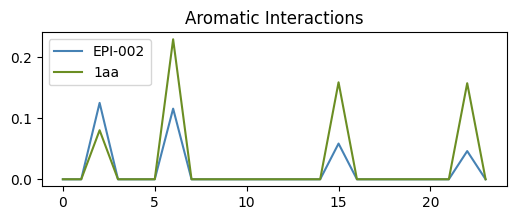

In [693]:
plt.figure(figsize=(6, 2))
for i, label, color in zip(any_aro, labels[1:], [ 'steelblue', 'olivedrab']):
    plt.plot(i.mean(0), label=label, color=color)
plt.legend()
plt.title("Aromatic Interactions")

 # Hydrophobic Contacts - should be same as usual and uses PBC by default

In [598]:
for index, path in enumerate(paths[1:]):
    
    traj = md.load(ligand_files[index], top=ligand_pdbs[index],
                  atom_indices = md.load(ligand_pdbs[index]).top.select('type C or type CL'),
                  stride=1)
    
    sequence = get_residues(traj)[0]

    ResidueDistances(traj=traj,
                     index_0=np.where(np.isin(sequence, resnames))[0],
                     index_1=np.where(np.isin(sequence, np.array(['EPI0', 'LIG1'])))[0]
                    ).save(path, 'hphob')

 # Hydrogen Bonding

# State Tables

In [626]:
import pandas
from pandas import DataFrame
from IPython.display import display, Markdown
cols = [r'Protein Contacts',  r'$S\alpha$', 'Dimer %', 'Ligand Contacts', 'Ternary %']


# grab everything from files, compute statistics per-state here - 

# grabbing from files and immediately contracting to coarse stats prevents memory from overflowing but is slower
for path, label, dtraj in zip(paths, labels, macro_states):

    rows = []

    rows.append(group_by(dtraj,
                        ResidueDistances.load(f'{path}/r1r2_ca_distance_dict.pkl').contacts(1).sum(-1),
                        np.mean))
    

    rows.append(group_by(dtraj, np.load(f'{path}/r1r2_sa.npy').sum(-1), np.mean))

    rows.append(100 * group_by(dtraj,
                           ResidueDistances.load(f'{path}/r1r2_ca_distance_dict.pkl').contacts(1).any(1).astype(int),
                           np.mean))

    if label == 'APO':
        
        display(Markdown(f'{label} State Observables'))
        display(pandas.DataFrame(np.array(rows).T.round(1), columns=cols[:3], index=np.arange(1, len(rows[0]) + 1)))
        
    
    else:

        rows.append(group_by(dtraj,
                    to_contacts(np.load(f'{path}/ligand_distances.npy'), 0.6).sum(-1),
                    np.mean))
        
        rows.append(100 * group_by(dtraj,
                                 prod([i.any(1) for i in split(to_contacts(np.load(f'{path}/ligand_distances.npy'), 0.6))]),
                                 np.mean).round(3))

        display(Markdown(f'{label} State Observables'))
        display(pandas.DataFrame(np.array(rows).T.round(1), columns=cols, index=np.arange(1, len(rows[0]) + 1)))

    

    

APO State Observables

Protein Contacts  $S\alpha$  Dimer %
1              98.3       13.0     99.0
2              73.2       15.3     98.7
3              37.4        7.8     72.6
4              41.0        9.1     72.5
5              30.9       10.2     61.4
6              33.1        5.1     56.1
7              34.7        2.0     61.8

EPI-002 State Observables

Protein Contacts  $S\alpha$  Dimer %  Ligand Contacts  Ternary %
1             100.1        7.3    100.0             12.8       67.7
2              57.4       10.6     94.2             15.7       74.2
3              53.5       11.6     88.3             11.1       58.7
4              24.4        7.4     52.7              5.4       25.7
5              67.1       18.3     97.3             12.6       81.2
6              53.9       18.4    100.0             17.8       94.5
7              34.0        3.1     61.9              4.0       19.7
8              71.5       13.7     89.8              8.9       52.8
9              39.1       10.8     78.7             12.8       63.1

1aa State Observables

Protein Contacts  $S\alpha$  Dimer %  Ligand Contacts  Ternary %
1               78.9       18.5     97.9             17.4       88.4
2               65.8       16.5     86.4             13.9       71.6
3               25.9       11.2     55.8             11.2       47.9
4               59.4       15.4     99.9             15.3       86.8
5               61.5       15.9    100.0             13.5       90.1
6               45.5       18.4    100.0             20.6      100.0
7               77.7       15.4    100.0             19.8      100.0
8               33.1       16.5     62.1             11.9       52.4
9               47.5        6.7     63.3             10.5       47.6
10              86.8        5.6     96.6              9.3       58.4

In [694]:
import numpy as np

def noe_sigma_from_r6(
    r6_avg_nm6,
    B0_T=14.1,         # Tesla, corresponds to 600 MHz spectrometer
    tau_c=5e-9,        # seconds (5 ns, typical for 15 kDa protein)
    gamma=2.67522e8,   # rad s⁻¹ T⁻¹ for proton
    mu0=4 * np.pi * 1e-7,      # H m⁻¹ (permeability of free space)
    hbar=1.0545718e-34         # J s (reduced Planck’s constant)
):
    """
    Compute NOE cross-relaxation rate σ (in s⁻¹) from ⟨r⁻⁶⟩ in nm⁻⁶.

    Parameters
    ----------
    r6_avg_nm6 : float or array-like
        Time-averaged ⟨r⁻⁶⟩ value(s), in nanometers⁻⁶.
    B0_T : float
        Magnetic field strength in Tesla. Default is 14.1 T (600 MHz).
    tau_c : float
        Rotational correlation time in seconds. Default is 5e-9 s.
    gamma : float
        Gyromagnetic ratio of proton in rad·s⁻¹·T⁻¹.
    mu0 : float
        Permeability of free space.
    hbar : float
        Reduced Planck’s constant.

    Returns
    -------
    sigma : float or array-like
        NOE cross-relaxation rate in s⁻¹.
    """

    # Physical prefactor: μ₀²·ℏ²·γ⁴ / [10·(4π)²]
    C = (mu0**2 * hbar**2 * gamma**4) / (10 * (4 * np.pi)**2)

    # Convert ⟨r⁻⁶⟩ from nm⁻⁶ to m⁻⁶ → multiply by (1e9)^6 = 1e54
    r6_avg_m6 = np.asarray(r6_avg_nm6) * 1e54

    # Larmor frequency
    omega0 = gamma * B0_T

    # Spectral density at ω₀
    J = tau_c / (1 + (omega0**2) * (tau_c**2))

    # Cross-relaxation rate σ = C × ⟨r⁻⁶⟩ × J(ω)
    sigma = C * r6_avg_m6 * J  # in s⁻¹
    return sigma


for file in protein_files:
    # get full trajectory sequence information
    traj = md.load(file, top=protein_pdb, stride=100)
    sequence, ca_index = get_residues(traj)
    resnames = sequence[ca_index]

    # slice trajectory into non-exchange-able hydrogens
    traj = traj.atom_slice(get_non_exchangeable_protons(traj))
    index = np.array([i for i, j in enumerate(residues) if 'TRP' in j])
    where = np.where(np.isin(get_residues(traj)[0], resnames))[0]
    pairs = np.concatenate([product(np.array([i]), j)
                            for i, j in zip(index, np.array_split(where, 2)[::-1])])
    
    d = 10 * md.compute_contacts(traj_slice(traj, 'not (resname TRP and (not name HD1))'), # remove non-target hydrogens 
                                 scheme='closest',
                                 contacts=index.reshape(-1, 2))[0]
    
    where = (d < 6).astype(bool)
    #noe = np.mean(where * (1 / d**6), 0).sum() / 2
    noe = np.mean((1 / d**6), 0).sum() / 2
    
    #print(d.shape)
    #noe = d.sum(-1).mean() / 2

    print(where.sum(-1).mean() / 2)
    print(noe)